## Incremental learning with River

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import GridSearchCV
import sys
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.spatial.distance import mahalanobis
import random
import matplotlib
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
import random
from river import anomaly
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from predict import binarize

In [4]:
X_train =      np.load(os.path.join(os.environ["Z24_DATA"], "features", "X_train_new.npy"))
X_test =       np.load(os.path.join(os.environ["Z24_DATA"], "features", "X_test_new.npy"))
labels_train = np.load(os.path.join(os.environ["Z24_DATA"], "features", "labels_train_new.npy"))
labels_test  = np.load(os.path.join(os.environ["Z24_DATA"], "features", "labels_test_new.npy"))

In [5]:
X_train.shape, \
X_test.shape

((544, 906), (68, 906))

In [6]:
# feature selection (see previous part -- xgboost binary)
subset_indices =  [673, 691, 191, 670]
len(subset_indices)

4

### Recreate original dataset

In [7]:
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 1224/17 = 72, where 1224 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices_temp = np.array(random.sample(range(nbr_splits), test_split))
    test_indices = np.append(test_indices, i*nbr_splits + test_indices_temp)
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices_temp]))

print(len(train_indices))

544


In [8]:
train_ctr = 0
test_ctr = 0
data_all = []
labels_all = []
for i in range(612):
    if i in train_indices:
        data_all.append(X_train[train_ctr])
        labels_all.append(labels_train[train_ctr])
        train_ctr += 1
    elif i in test_indices:
        data_all.append(X_test[test_ctr])
        labels_all.append(labels_test[test_ctr])
        test_ctr += 1

In [9]:
y_all = binarize(labels_all) # is the labels of all instances 
data_all = np.array(data_all) # are all the instances

In [10]:
data_all_top = data_all[:, subset_indices] 
healthy_data = data_all_top[y_all == 0]
damage_data = data_all_top[y_all == 1]
healthy_data.shape, damage_data.shape

((288, 4), (324, 4))

In [11]:
# for occ labels are defined differently
damage_labels  = -1*np.ones(damage_data.shape[0])
healthy_labels =    np.ones(healthy_data.shape[0])

### Test and training dataset

In [12]:
healthy_data.shape, damage_data.shape

((288, 4), (324, 4))

In [13]:
pca = PCA(n_components=3)
sc = StandardScaler()

sc.fit(healthy_data[0:36])
pca.fit(healthy_data[0:36])

PCA(n_components=3)

In [14]:
healthy_data_top = pca.transform(sc.transform(healthy_data))
damage_data_top  = pca.transform(sc.transform(damage_data))

healthy_data.shape, damage_data.shape, healthy_data_top.shape, damage_data_top.shape

((288, 4), (324, 4), (288, 3), (324, 3))

## Visualization (static)

### Time color-coded - static

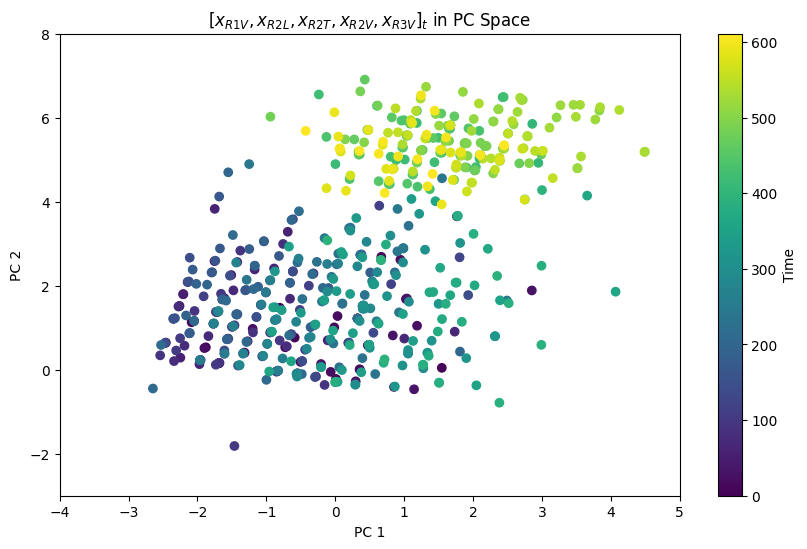

In [15]:
import matplotlib
%matplotlib inline

data_plot = np.vstack([healthy_data_top, damage_data_top])
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 0], data_plot[:, 1], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

# axes limits
plt.xlim((-4, 5)) # for PC 1 
plt.ylim((-3, 8)) # for PC 2
#plt.zlim((-5, 3)) # for PC 3

plt.show()

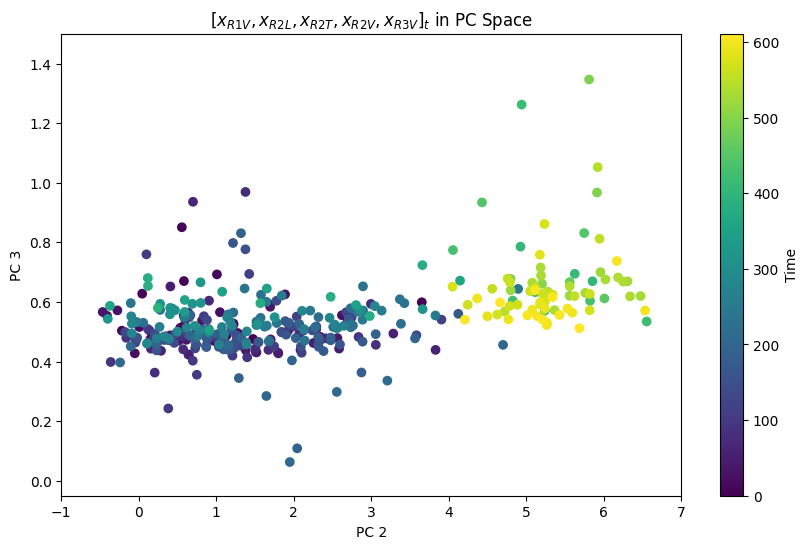

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 1], data_plot[:, 2], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
plt.xlim((-1, 7)) # for PC 2
plt.ylim((-0.05, 1.5)) # for PC 3
plt.show()

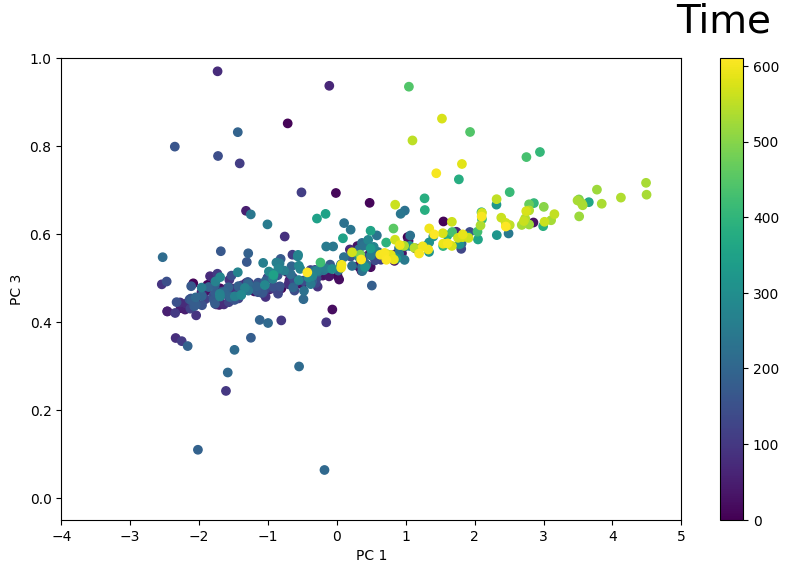

In [24]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_plot[:, 0], data_plot[:, 2], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 3')
cbar = plt.colorbar(scatter, label='Time')
plt.title('ASKA ', color ="white", fontsize = 35)
plt.xlim((-4, 5)) # for PC 1 
cbar.set_label('Time', size=28, labelpad=-40, y=1.12, rotation=0)
plt.ylim((-0.05, 1)) # for PC 3
plt.show()

### Healthy vs damaged scatter plots - static

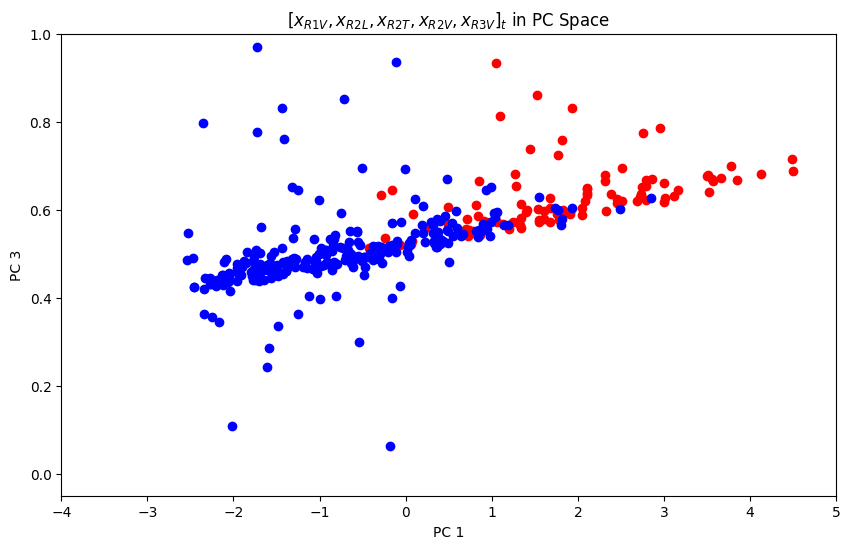

In [25]:
%matplotlib inline

data_plot = np.vstack([healthy_data_top, damage_data_top])
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 0], data_plot[healthy_data.shape[0]:, 2],  color='red', label = 'Damage')
plt.scatter(data_plot[:healthy_data.shape[0], 0], data_plot[:healthy_data.shape[0], 2], color='blue', label = 'Healthy')
plt.xlabel('PC 1')
plt.ylabel('PC 3')
#plt.legend(fontsize = 15)
plt.ylim((-0.05, 1)) # for PC 3
plt.xlim((-4, 5)) # for PC 1 
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

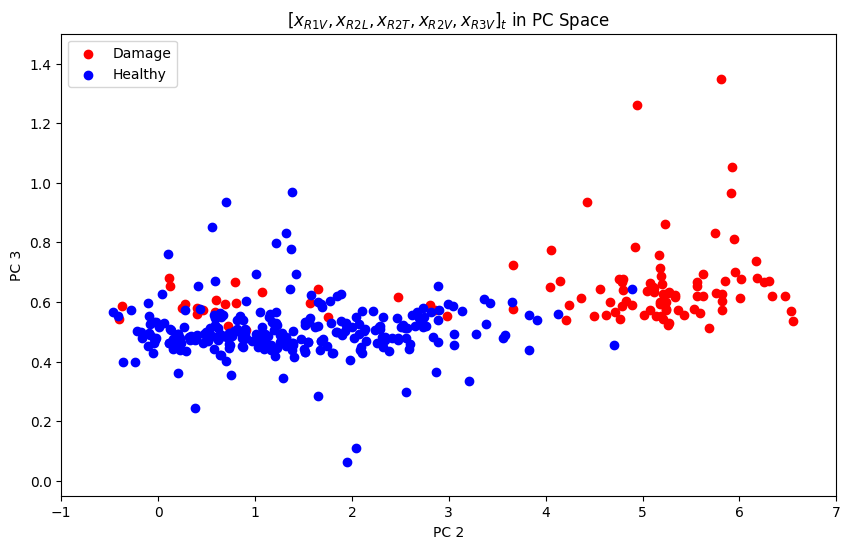

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 1], data_plot[healthy_data.shape[0]:, 2],  color='red', label = 'Damage')
plt.scatter(data_plot[:healthy_data.shape[0], 1], data_plot[:healthy_data.shape[0], 2], color='blue', label = 'Healthy')
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.legend()
#plt.xlim((-4, 1)) # for PC 1 
plt.xlim((-1, 7)) # for PC 2
plt.ylim((-0.05, 1.5)) # for PC 3
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

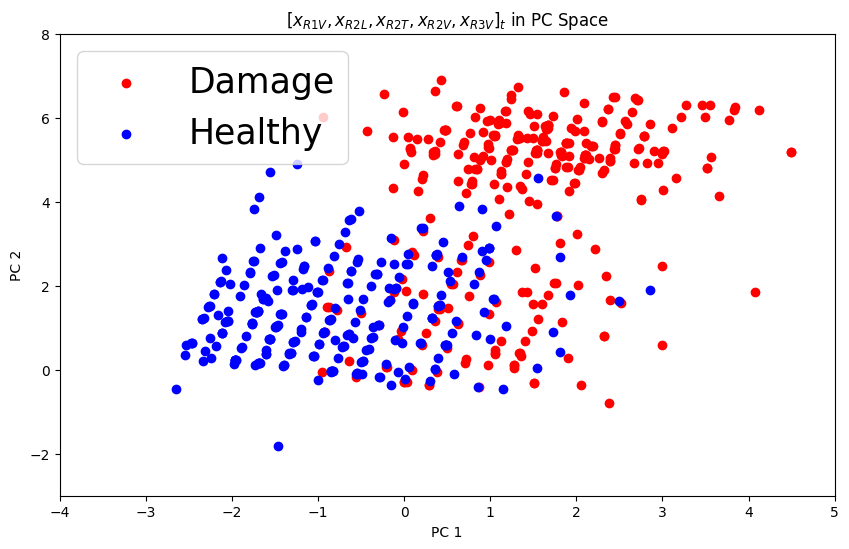

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 0], data_plot[healthy_data.shape[0]:, 1],  color='red', label = 'Damage')
plt.scatter(data_plot[:healthy_data.shape[0], 0], data_plot[:healthy_data.shape[0], 1], color='blue', label = 'Healthy')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xlim((-4, 5)) # for PC 1 
plt.ylim((-3, 8)) # for PC 2
plt.legend(fontsize = 25)
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [223]:
np.save("data_plot.npy", data_plot)

### Healthy vs damaged - animated

In [19]:
import matplotlib.animation as animation
#import matplotlib
#matplotlib.use("QtAgg")

data_plot = np.vstack([healthy_data_top, damage_data_top])
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
ax.set_xlim(data_plot[:, 0].min() - 1, data_plot[:, 0].max() + 1)
ax.set_ylim(data_plot[:, 1].min() - 1, data_plot[:, 1].max() + 1)
current_num_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Animation function for showing scatter points one by one
def update(num):
    point = ax.scatter(data_plot[num, 0], data_plot[num, 1], color='blue' if num < healthy_data.shape[0] else 'red', marker = 'o', s=30)
    current_num_text.set_text(f'Instance: {num}')
    return point, current_num_text

# Creating the new animation
ani = animation.FuncAnimation(fig, update, frames=data_plot.shape[0], interval=10, blit=True)
ani.save('pc1pc2animation.gif', writer='pillow')
plt.close()

Traceback (most recent call last):
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py", line 309, in process
    func(*args, **kwargs)
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py", line 908, in _start
    self.event_source.add_callback(self._step)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'add_callback'


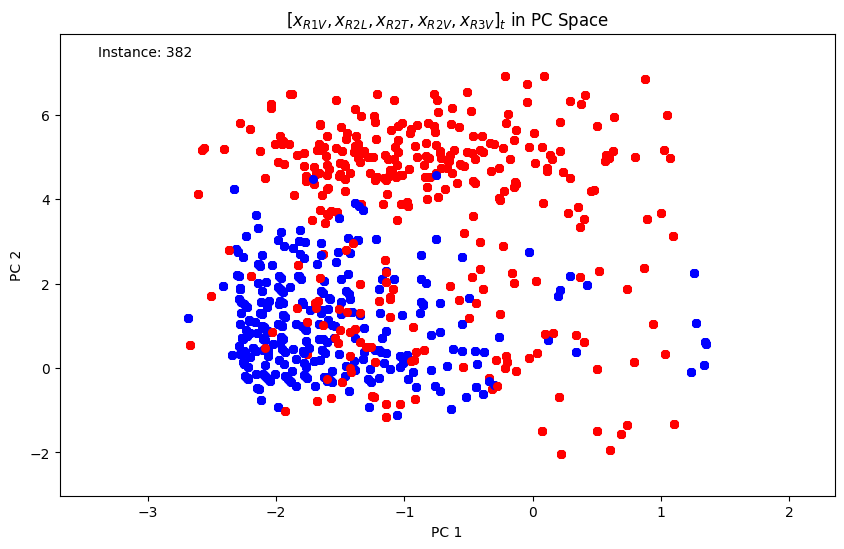

In [20]:
%matplotlib inline 
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 3')
ax.set_title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
ax.set_xlim(data_plot[:, 0].min() - 1, data_plot[:, 0].max() + 1)
ax.set_ylim(data_plot[:, 2].min() - 1, data_plot[:, 2].max() + 1)
current_num_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Animation function for showing scatter points one by one
def update(num):
    point = ax.scatter(data_plot[num, 0], data_plot[num, 2], color='blue' if num < healthy_data.shape[0] else 'red', marker = 'o', s=30)
    current_num_text.set_text(f'Instance: {num}')
    return point, current_num_text

# Creating the new animation
ani = animation.FuncAnimation(fig, update, frames=data_plot.shape[0], interval=10, blit=True)
ani.save('pc1pc3animation.gif', writer='pillow')
plt.close()  # Close the plot to finalize the animation file creation

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('PC 2')
ax.set_ylabel('PC 3')
ax.set_title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
ax.set_xlim(data_plot[:, 1].min() - 1, data_plot[:, 1].max() + 1)
ax.set_ylim(data_plot[:, 2].min() - 1, data_plot[:, 2].max() + 1)
current_num_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Animation function for showing scatter points one by one
def update(num):
    point = ax.scatter(data_plot[num, 1], data_plot[num, 2], color='blue' if num < healthy_data.shape[0] else 'red', marker = 'o', s=30)
    current_num_text.set_text(f'Instance: {num}')
    return point, current_num_text

# Creating the new animation
ani = animation.FuncAnimation(fig, update, frames=data_plot.shape[0], interval=10, blit=True)
ani.save('pc2pc3animation.gif', writer='pillow')
plt.close()  # Close the plot to finalize the animation file creation

In [238]:
corr = np.corrcoef(data_all_top, rowvar=False)
print(corr.shape)

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='viridis', vmax=1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

(4, 4)


In [18]:
param_grid_occ_svm = {
    'nu': [0.01, 0.1, 0.2], 
    'gamma': ['scale', 'auto'],
    'tol': [1e-3, 1e-2, 1e-1],
    'kernel': ['rbf']
} # rbf by default

### Story
Train OCC on first health scenario, then data comes one by one. Each data point that arrives is added to the support of the OCC. The OCC detects weather each new arriving point is anomalous or not. After accumulation of all healthy points into the support occurs, we test on all damage data to see whether it will report healthy or damaged. Note, to be realistic the support should be implemented incrementally, i.e. naively storing all arriving instances is not realistic.   

In [28]:
print(pca.components_)

[[-0.21921757 -0.02498559 -0.03682812 -0.97466049]
 [-0.9752623  -0.02185074 -0.00134864  0.21996404]
 [-0.00899243 -0.01591857  0.99920862 -0.03532506]]


In [29]:
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib.sankey import Sankey
import matplotlib.pyplot as plt
components = pca.components_
n_features = components.shape[1]
n_components = components.shape[0]
import plotly.graph_objects as go

# Example PCA components for illustration
pca_components_example = pca.components_

# Define nodes (PCA components and original features)
node_labels = ['PCA 1', 'PCA 2', 'PCA 3', 'rel_pos_5_trans_R2L', 'std_prom_trans_R2T', 'fft_range_50_R2V', 'rel_pose_2_trans_R2L']

# Define links
source_nodes = []
target_nodes = []
values = []

for i in range(n_components):
    for j in range(n_features):
        source_nodes.append(i)
        target_nodes.append(n_components + j)
        values.append(abs(pca_components_example[i, j]))

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = node_labels,
    ),
    link = dict(
      source = source_nodes, 
      target = target_nodes,
      value = values
    ))])

fig.update_layout(title_text="PCA Component Contributions to Features", font_size=20)
fig.show()



### Base stream learner

In [30]:
import copy
class StreamLearning:
    def __init__(self, h_data, d_data, clf, min_points_for_retraining = 3, reset_clf = False):
        self.h_data = h_data # healthy state data
        self.d_data = d_data # damage state data
        self.clf = clf       # the OCC
        self.ctr = 36        # current healthy instance (first health scenario is used for initialization of the model) 
        self.an_inst = []    # stores the indices of the anomalous instances
        self.d_preds = []
        self.h_preds = []
        self.d_pred_proba = []
        self.h_pred_proba = []
        self.all_data = np.vstack((self.h_data, self.d_data))
        self.val_scores = []
        self.min_points_for_retraining = min_points_for_retraining
        self.reset_clf = reset_clf # whether or not to reset classifier on anomaly detection
        self.base_clf = copy.deepcopy(clf)
        self.all_data_backup = np.copy(self.all_data)

    def support_include(self): # include into the support
        self.clf.update(self.all_data[self.ctr])
        self.ctr += 1

    def is_cur_anomaly(self):
        cur_inst = self.all_data[self.ctr]
        self.h_pred_proba.append(self.clf.predict_proba(cur_inst)[0])
        if self.clf.predict(cur_inst)[0] < 0:
            # false positive found, add it to this list
            self.an_inst.append(self.ctr)
            # reset model only if reset set to true
            if self.reset_clf:
                self.retrain(self.ctr)

    def retrain(self, anomaly_idx):
        # when anomaly encountered retrain on last 36 points
        self.clf = copy.deepcopy(self.base_clf)
        # make sure to not sample across boundaries
        scenario_of_anomaly_idx = int(anomaly_idx/36)
        previous_scenario = scenario_of_anomaly_idx - 1
        is_first_instance_in_scenario = int(anomaly_idx % 36) # is the anomalous instance, the first instance in its state?
        current_or_previous_scenario =  previous_scenario if is_first_instance_in_scenario == 0 else scenario_of_anomaly_idx # if yes, use the previous scenario as we have not accumulated enough of the current scenario
        # for the covariance matrix to be inverted inside predict of GaussianIncremental, we need at least three points
        nbr_points = anomaly_idx - current_or_previous_scenario*36
        # for cases where we need to initialize with at least self.min_points_for_training
        for j in range(max(1, int(self.min_points_for_retraining / nbr_points))):
            for i in range(current_or_previous_scenario*36, anomaly_idx):
                self.clf.update(self.h_data[i])
        remainder = self.min_points_for_retraining % nbr_points    
        if (remainder) != 0:
            #print("Adding more points to prevent singularity in OCC")
            for j in range(remainder):
                self.clf.update(self.h_data[anomaly_idx - 1 - j]) # just add more of the last points

    def final_evaluation(self):
        # Loop until anomaly is detected
        p_score = self.clf.predict_proba(self.all_data[self.ctr])[0]
        score = self.clf.predict(self.all_data[self.ctr])[0]
        self.first_dam_idx = 0 # how many points do we need to wait until damage is detected (if 1st dam. index detected, it is 0)
        while score > 0 and self.ctr < self.all_data.shape[0]:
            self.h_pred_proba.append(p_score) 
            # line above implies that h_pred_proba is no longer simply of length h_data, 
            # but can be slightly longer depending on how long it takes for the clf to realize it is in the damage zone
            self.support_include()
            self.first_dam_idx = self.first_dam_idx + 1
            if self.ctr == self.all_data.shape[0]:
                break
            p_score = self.clf.predict_proba(self.all_data[self.ctr])[0]
            score = self.clf.predict(self.all_data[self.ctr])[0]

        # compute preds (for final evaluation). Note: avoid using self.h_preds since it is done post-facto
        self.d_preds = self.clf.predict(self.d_data[self.first_dam_idx:]) # since some of the damage may have been seen (i.e. included to the support), we don't consider them for test
        self.h_preds = self.clf.predict(self.h_data)
        self.d_pred_proba = self.clf.predict_proba(self.d_data[self.first_dam_idx:])

    def cross_validate(self):
        # call  loop with different cuts used for cross-validation
        for i in range(1, 8): # we don't cross validate on first one
            self.ctr = 36
            self.loop(i)

    def init_clf(self):
        # initialize 
        for i in range(36):
            self.clf.update(self.h_data[i])

    def loop(self, i = -1):
        if i != -1:
            cv_set_len = 36 # size of CV set
            n_iters = self.h_data.shape[0] - self.ctr - cv_set_len
            self.cv_set = self.h_data[i*36:(i+1)*36]
            self.all_data = np.vstack((self.all_data_backup[:i*36], self.all_data_backup[(i+1)*36:])) 
        else:
            n_iters = self.h_data.shape[0] - self.ctr
            self.cv_set = None

        # initialize the model
        self.init_clf()
        
        # simulate data intake
        for i in range(n_iters):
            self.is_cur_anomaly()
            self.support_include()
        
        # find validation score
        if not(self.cv_set is None):
            pred_val = np.array(self.clf.predict(self.cv_set)).reshape(-1, 1)
            acc_val  = np.sum(pred_val > 0)/len(pred_val) 
            self.val_scores.append(acc_val)

        # the final evaluation
        self.final_evaluation()

In [31]:
def print_metrics(sl: StreamLearning):
    print("cor_d_preds", np.sum(np.array(sl.d_preds) < 0), "cor_h_preds (do not use)", np.sum(np.array(sl.h_preds) > 0), "d_pred_len", len(sl.d_preds), "h_pred_len", len(sl.h_preds))
    print("fp count", len(sl.an_inst), "first damage index", sl.first_dam_idx)

In [32]:
from scipy.interpolate import griddata
def plot_decision_boundary_2D(model, X_train, y_train):
    # Reduce dimension to 2D for report
    pca = PCA(n_components=2)
    X_train_2d = pca.fit_transform(X_train)

    # Grid (not for plotting but for finding the decision boundary)
    x = np.linspace(X_train[:,0].min()-1, X_train[:,0].max()+1, 100)
    y = np.linspace(X_train[:,1].min()-1, X_train[:,1].max()+1, 100)
    z = np.linspace(X_train[:,2].min()-1, X_train[:,2].max()+1, 100)
    xx, yy, zz = np.meshgrid(x, y, z)
    grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

    # Evaluate decision function
    decision_values = model.decision_function(grid)
    #decision_signs = np.sign(decision_values).reshape(xx.shape)
    values = np.sign(decision_values).reshape((-1, 1))

    # Transform grid to 2D
    grid_two = pca.transform(grid)
    x_min = grid_two[:,0].min() - 1
    x_max = grid_two[:,0].max() + 1
    y_min = grid_two[:,1].min() - 1
    y_max = grid_two[:,1].max() + 1

    grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j] 
    grid_z = griddata((grid_two[:,0], grid_two[:,1]), values.flatten(), (grid_x, grid_y), method='linear')

    #x_grid_two = np.linspace(grid_two[:,0].min()-1, grid_two[:,0].max()+1, 50)
    #y_grid_two = np.linspace(grid_two[:,1].min()-1, grid_two[:, 1].max()+1, 50)

    plt.contourf(grid_x, grid_y, grid_z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='k', s=50)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title("2D Decision Boundary")
    plt.show()

In [33]:
def plot_decision_boundary_2D_v2(model, X_train, y_train):
    # Perform PCA to reduce data to 2D
    pca = PCA(n_components=2)
    X_train_2d = pca.fit_transform(X_train)

    # Create a grid for plotting
    x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
    y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    # Transform grid using PCA inverse
    grid = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])

    # Evaluate decision function on the transformed grid
    decision_values = model.decision_function(grid)
    decision_signs = np.array(decision_values).reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(8, 5))
    contourf_plot = plt.contourf(xx, yy, decision_signs, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Add a color bar
    plt.colorbar(contourf_plot)

    # Plot the training points (2D projection)
    plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm, s=50)

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title("2D Decision Boundary")
    plt.show()

In [34]:
def plot_decision_boundary(model, X_train, y_train):
    x = np.linspace(X_train[:,0].min()-1, X_train[:,0].max()+1, 50)
    y = np.linspace(X_train[:,1].min()-1, X_train[:,1].max()+1, 50)
    z = np.linspace(X_train[:,2].min()-1, X_train[:,2].max()+1, 50)
    xx, yy, zz = np.meshgrid(x, y, z)
    grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

    # Evaluate the model's decision function
    decision_values = model.decision_function(grid)
    decision_signs = np.sign(decision_values).reshape(xx.shape)

    # Check for sign changes along each axis
    diff_x = np.diff(decision_signs, axis=0)
    diff_y = np.diff(decision_signs, axis=1)
    diff_z = np.diff(decision_signs, axis=2)

    # Combine the differences to locate boundary points
    boundary_mask = np.zeros_like(decision_signs, dtype=bool)
    boundary_mask[:-1,:,:] |= diff_x != 0
    boundary_mask[:,:-1,:] |= diff_y != 0
    boundary_mask[:,:,:-1] |= diff_z != 0

    boundary_points = grid[boundary_mask.ravel()]

    # Visualize the decision boundary
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the boundary points
    ax.scatter(boundary_points[:, 0], boundary_points[:, 1], boundary_points[:, 2], color='orange', s=8, alpha=0.5)
    ax.set_xlim((-4, 1))
    ax.set_ylim((-1, 6))
    ax.set_zlim((-5, 3))
    #ax.plot_surface(boundary_points[:, 0], boundary_points[:, 1], boundary_points[:, 2], color='orange', alpha=0.5)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap=plt.cm.coolwarm, s=50)

    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    plt.title("3D Decision Boundary of OCC-SVC")
    plt.show()

### Gaussian ellipsoid

In [35]:
from scipy.spatial import distance
from scipy.stats import chi2

class IncrementalGaussianFitter:
    def __init__(self):
        self.mean = np.array([0.0, 0.0, 0.0])
        self.covariance = np.eye(3)
        self.count = 0

    def update(self, new_point):
        self.count += 1
        old_mean = self.mean.copy()
        self.mean += (new_point - self.mean) / self.count
        self.covariance = ((self.count - 1) * self.covariance + 
                           np.outer(new_point - self.mean, new_point - self.mean)) / self.count

    def get_mean(self):
        return self.mean

    def get_covariance(self):
        return self.covariance
    
    def predict_proba(self, points):
        if points.ndim == 1:
            points = np.array([points])
        confidence_level=0.95
        threshold = chi2.ppf(confidence_level, df=3)  # df=3 for 3 dimensions
        mahalanobis_distances = np.array([distance.mahalanobis(point, self.mean, np.linalg.inv(self.covariance)) 
                                          for point in points])
        #print(self.covariance)
        return (mahalanobis_distances ** 2) - threshold # the higher the more likely an anomaly
    
    def decision_function(self, points):
        return self.predict_proba(points)
    
    # unlike predict_proba, negative corresponds to an anomaly, positive to an inlier
    def predict(self, points):
        if points.ndim == 1:
            points = np.array([points])
        confidence_level=0.95
        threshold = chi2.ppf(confidence_level, df=3)  # df=3 for 3 dimensions
        mahalanobis_distances = np.array([distance.mahalanobis(point, self.mean, np.linalg.inv(self.covariance)) 
                                          for point in points])
        result = mahalanobis_distances ** 2 <= threshold
        result = [2*int(el) - 1  for el in result]
        return result

In [36]:
# only get the CV score, not params in this case 
slg = StreamLearning(healthy_data_top, damage_data_top, IncrementalGaussianFitter())
slg.cross_validate()
np.mean(slg.val_scores) # score: 0.8

0.9206349206349207

In [37]:
# now, without CV and WITHOUT RETRAIN ON ANOMALY, get the performance metrics
slg = StreamLearning(healthy_data_top, damage_data_top, IncrementalGaussianFitter())
slg.loop()
print_metrics(slg)

cor_d_preds 301 cor_h_preds (do not use) 264 d_pred_len 324 h_pred_len 288
fp count 23 first damage index 0


In [43]:
# train without cross validation and WITH RETRAIN ON ANOMALY
slg_reset = StreamLearning(healthy_data_top, damage_data_top, IncrementalGaussianFitter(), min_points_for_retraining=2, reset_clf=True)
slg_reset.loop()
print_metrics(slg_reset)

cor_d_preds 312 cor_h_preds (do not use) 228 d_pred_len 324 h_pred_len 288
fp count 50 first damage index 0


c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\spatial\distance.py:1023: RuntimeWarning:

invalid value encountered in sqrt



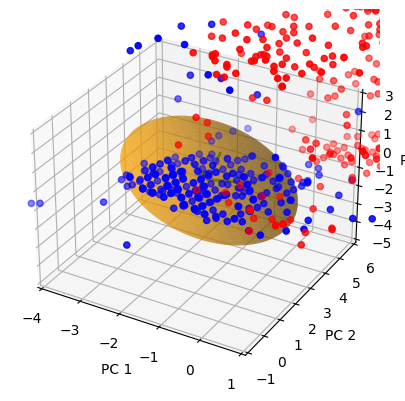

In [45]:
eigenvalues, eigenvectors = np.linalg.eig(slg.clf.covariance)

# Create a grid for the ellipsoid
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
y = 2*np.sqrt(eigenvalues[0])*np.outer(np.cos(u), np.sin(v)) # two standard deviation to cover 95% of the confidence 
x = 2*np.sqrt(eigenvalues[1])*np.outer(np.sin(u), np.sin(v))
z = 2*np.sqrt(eigenvalues[2])*np.outer(np.ones(np.size(u)), np.cos(v))

# Scale each point by the square root of the corresponding eigenvalue (standard deviation)
for i in range(len(x)):
    for j in range(len(x)):
        [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], eigenvectors) + slg.clf.mean

# Create a 3D plot
fig = plt.figure()


ax = fig.add_subplot(111, projection='3d')
ax.axis('auto')

# Plot the original points
ax.scatter(healthy_data_top[:, 0], healthy_data_top[:, 1], healthy_data_top[:, 2], color='blue', marker='o')
ax.scatter(damage_data_top[:, 0], damage_data_top[:, 1], damage_data_top[:, 2], color='red', marker='o')
ax.set_xlim((-4, 1))
ax.set_ylim((-1, 6))
ax.set_zlim((-5, 3))

# Plot the ellipsoid
ax.plot_surface(x, y, z, color='orange', alpha=0.5)

# Plot principal axes as line segments
for i in range(3):
    axis_start = np.zeros(3) + slg.clf.mean
    axis_end =  eigenvectors[:, i] * np.sqrt(eigenvalues[i]) + slg.clf.mean  # Scale factor for visibility
    ax.plot([axis_start[0], axis_end[0]], [axis_start[1], axis_end[1]], [axis_start[2], axis_end[2]], color='green', linewidth=2)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# save pc1pc2slg, pc2pc3slg, pc1pc3slg
plt.show()

In [46]:
import seaborn as sns
%matplotlib inline
def plot_anom(sl :StreamLearning, title):
    sns.reset_defaults()
    sns.reset_orig()

    plt.figure(figsize=(15, 6))
    nbr_epochs = healthy_data_top.shape[0] - 36 + damage_data_top.shape[0]
    print(nbr_epochs)

    an_scores = np.hstack((sl.h_pred_proba, sl.d_pred_proba)).reshape(-1, 1)
    print(len(range(0, nbr_epochs+1, 36)))
    for i in range(0, nbr_epochs+1, 36):
        plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

    # scale and plot the bars
    sc = StandardScaler()
    obs = np.arange(len(an_scores))
    std_entropies = sc.fit_transform(an_scores).flatten()
    
    plt.axvspan(36*7, 36*16, color='yellow', alpha=0.08)
    plt.bar(obs, std_entropies)
    plt.ylim(0, 1.15*max(std_entropies))

    plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
    plt.ylabel('Standardized anomaly score')
    plt.title(title)
    text_pos = [i+18 for i in range(0, nbr_epochs, 36)]
    
    # print title for each state
    for idx, pos in enumerate(text_pos):
        str_capt =  f'DS {idx+2}'
        plt.text(pos, max(std_entropies)*1.1, str_capt, ha='center', color='red')

    plt.show()

In [48]:
def plot_grid(sl: StreamLearning):
    # Standardize anomaly scores of the healthy 
    sch = StandardScaler()
    std_hscores = sch.fit_transform(np.array(sl.h_pred_proba).reshape(-1, 1)).flatten()

    # and the damage data
    scd = StandardScaler()
    std_dscores = scd.fit_transform(np.array(sl.d_pred_proba).reshape(-1, 1)).flatten()

    # Normalize the scores to [0, 1] for color mapping
    norm = MinMaxScaler()
    norm_hscores = norm.fit_transform(std_hscores.reshape(-1, 1)).flatten()
    norm_dscores = norm.fit_transform(std_dscores.reshape(-1, 1)).flatten()

    # Get colors for them based on normalized scores
    reds = sns.color_palette("Reds", n_colors=20)
    blues = sns.color_palette("Blues", n_colors=20)

    # False predictions
    fp_idx = np.array(sl.an_inst).astype(int) - 36
    fn_before_detection  = np.arange(sl.h_data.shape[0] - 36, sl.h_data.shape[0] - 36 + sl.first_dam_idx)
    fn_idx = np.where(np.array(sl.d_preds) > 0)[0] + sl.first_dam_idx + sl.h_data.shape[0] - 36
    false_preds = np.hstack((fp_idx, fn_before_detection, fn_idx))
    pred_mask = np.zeros(16*36) # the predictions mask, where 1 indicates false pred, 0 true pred
    pred_mask[false_preds] = 1
    false_pred_per_class = np.array([np.sum(pred_mask[i*36: (i+1)*36])/36 for i in range(16)]) # misclassification percentage per state

    # Array of anomaly scores
    array = np.hstack((norm_hscores, norm_dscores)).reshape((16, 36))

    # Set grid size
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), 
                               gridspec_kw={'width_ratios': [12, 4], 'wspace': -0.01, 'height_ratios': [1]})
    
    # Healthy states
    for i in range(7): # number of states
        for j in range(36): # number of samples per state
            ax1.scatter(j, i, color=blues[int(array[i, j] * 19)], s=100, marker='s' if (i*36 + j) not in false_preds else 'x')
        ax1.text(-1, i, f"State {i+2}", color = 'gray', verticalalignment='center', horizontalalignment='right')
    
    i = 7
    for j in range(36): # number of samples per state
        ax1.scatter(j, i, color=blues[int(array[i, j] * 19)] if j < sl.first_dam_idx else reds[int(array[i, j] * 19)] , s=100, marker = 's' if (i*36 + j) not in false_preds else 'x')
    ax1.text(-1, i, f"State {i+2}", color = 'gray', verticalalignment='center', horizontalalignment='right')

    # Damage states
    for i in range(8, 16): # number of states
        for j in range(36): # number of samples per state
            ax1.scatter(j, i, color=reds[int(array[i, j] * 19)], s=100, marker = 's' if (i*36 + j) not in false_preds else 'x')
        ax1.text(-1, i, f"State {i+2}", color = 'gray', verticalalignment='center', horizontalalignment='right')

    # Adjusting the plot
    ax1.invert_yaxis()
    ax1.axis('off')
    ax1.set_title("Anomaly Scores and False Predictions")
    
    # Now the horizontal bar plot
    bar_values = false_pred_per_class
    ax2.barh(np.arange(16)*5.2, bar_values, align = 'center', height=3, color='green', alpha = 0.4)  # Adjust y positions for spacing
    ax2.set_yticks(np.arange(16)*5.2)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    #ax2.set_yticklabels([f"Row {i+1}" for i in range(16)])
    ax2.invert_yaxis()  # To align with the grid plot
    ax2.yaxis.set_visible(False)
    ax2.set_title("False Prediction Rate")
    ax2.set_xlim(0, 1)  # Ensuring the x-axis goes from 0 to 1

    plt.tight_layout()
    plt.show()

In [49]:
def plot_colored_prog(sl: StreamLearning, title: str, width_an = 1):
    # standardize anomaly scores of the healthy 
    sch = StandardScaler()
    std_hscores = sch.fit_transform(np.array(sl.h_pred_proba).reshape(-1, 1)).flatten()

    # and the damage data
    scd = StandardScaler()
    std_dscores = scd.fit_transform(np.array(sl.d_pred_proba).reshape(-1, 1)).flatten()

    # Normalize the scores to [0, 1] for color mapping
    norm = MinMaxScaler()
    norm_hscores = norm.fit_transform(std_hscores.reshape(-1, 1)).flatten()
    norm_dscores = norm.fit_transform(std_dscores.reshape(-1, 1)).flatten()

    # Get colors for them based on normalized scores
    reds = sns.color_palette("Reds", n_colors=20)
    blues = sns.color_palette("Blues", n_colors=20)
    
    # Map scores to colors
    h_colors = [blues[int(score * 19)] for score in norm_hscores]
    d_colors = [reds[int(score * 19)] for score in norm_dscores]

    # Combine the colors for plotting
    colors = np.array(h_colors + d_colors)
    fig, ax = plt.subplots(figsize=(15, 2))

    # Setting the bar width to fully cover the plot area
    values = np.ones(len(np.hstack((std_hscores, std_dscores))))
    bar_width = 1.0 / len(values) * len(values)
    fp_idx = np.array(sl.an_inst).astype(int) - 36
    fn_before_detection  = np.arange(sl.h_data.shape[0] - 36, sl.h_data.shape[0] - 36 + sl.first_dam_idx)
    fn_idx = np.where(np.array(sl.d_preds) > 0)[0] + sl.first_dam_idx + sl.h_data.shape[0] - 36
    n_ep = len(colors)

    # Scenario boundaries
    for i in range(0, n_ep+1, 36):
        plt.axvline(x=i, color='gray', alpha = 0.5, linestyle=':', linewidth=1.1, ymax = 0.85)

    # Plotting each bar with the new width
    for i in range(len(values)):
        ax.bar(i, values[i], color=colors[i], width=bar_width, align='edge')
        # Adding a vertical dashed line through the center of each bar incorrectly classified
        if i in fp_idx or i in fn_idx or i in fn_before_detection:
            center_of_bar = i + bar_width / 2
            ax.axvline(center_of_bar, color='green', alpha =1, linestyle='-', linewidth=width_an, ymin=0.7, ymax=1.3)

    # Add scenario labels
    text_pos = [i+18 for i in range(0, n_ep, 36)]
    for idx, pos in enumerate(text_pos):
        str_capt =  f'State {idx+2}'
        plt.text(pos, -0.1, str_capt, ha='center', color='gray')

    # Removing x-ticks as bars will cover the entire x-axis
    ax.set_xticks([])
    ax.axis('off')
    ax.set_ylim((0, 1.15))

    # Additional plot formatting
    plt.xlabel("3D Instance")
    plt.ylabel("")
    plt.title(title)
    plt.show()

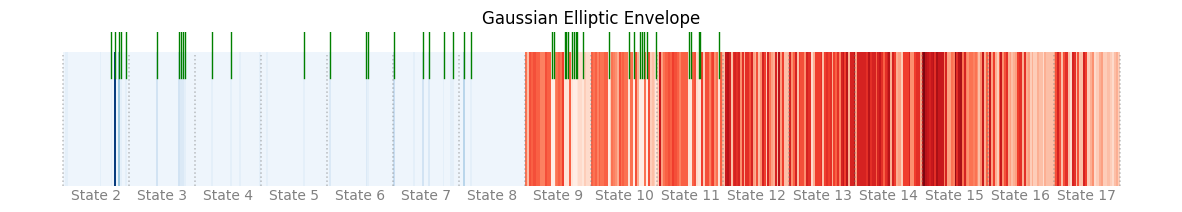

In [50]:
plot_colored_prog(slg, "Gaussian Elliptic Envelope")

C:\Users\amroa\AppData\Local\Temp\ipykernel_18748\3049143631.py:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



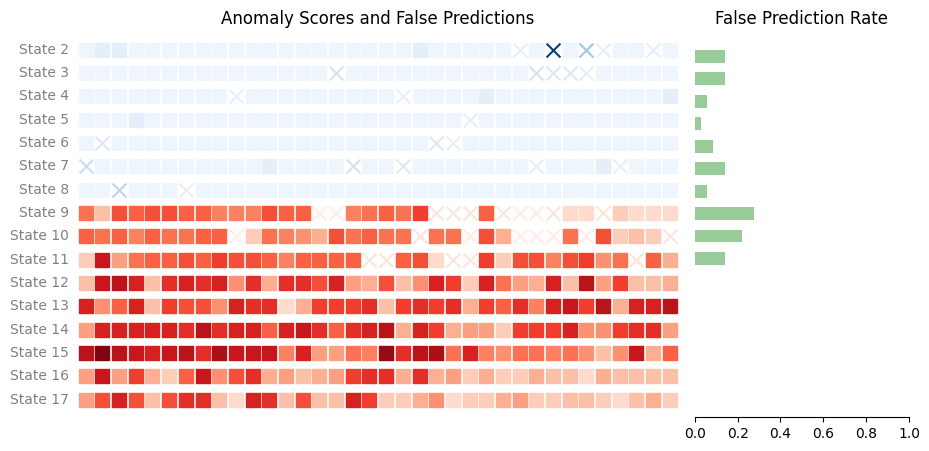

In [51]:
plot_grid(slg)

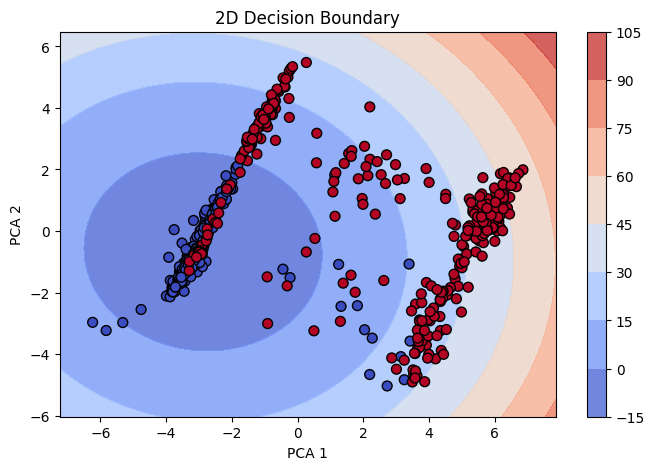

In [52]:
plot_decision_boundary_2D_v2(slg.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

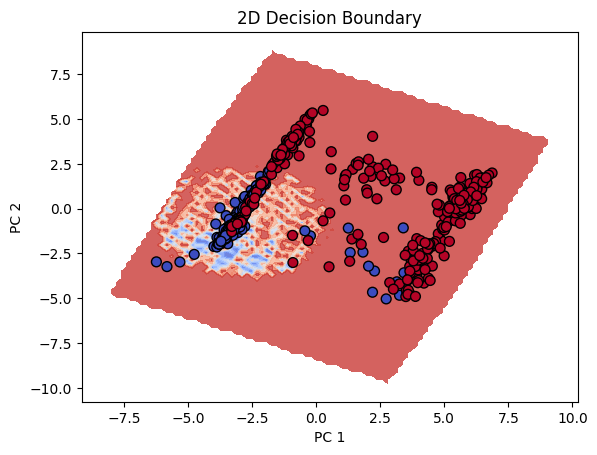

In [53]:
plot_decision_boundary_2D(slg.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

576
17


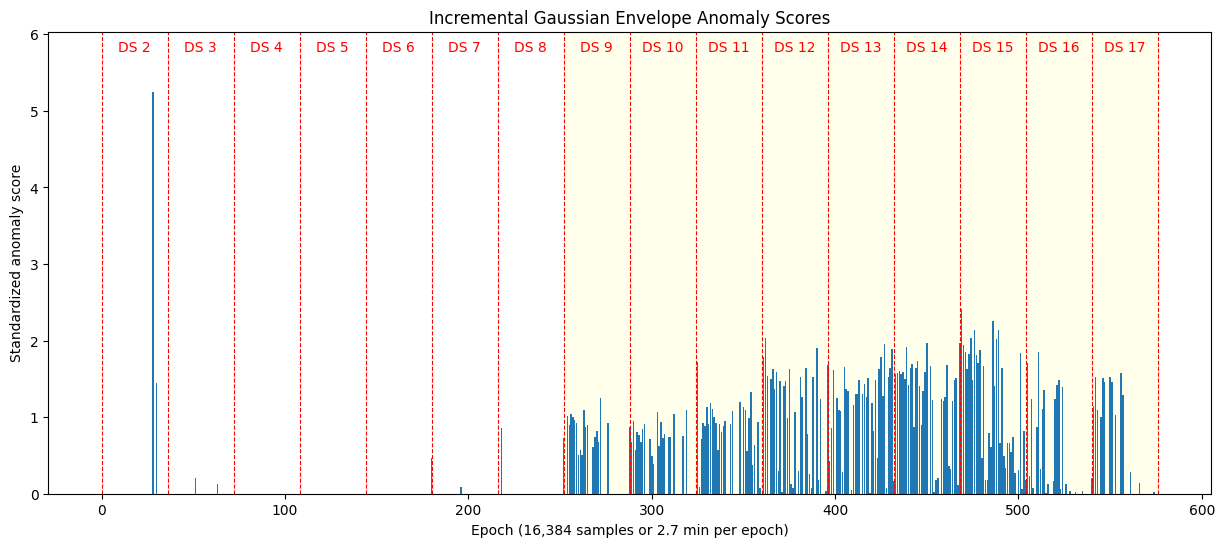

In [54]:
plot_anom(slg, "Incremental Gaussian Envelope Anomaly Scores")

### Online one class SVM

In [55]:
healthy_data_top.shape, damage_data_top.shape

((288, 3), (324, 3))

In [56]:
from sklearn.svm import OneClassSVM
from scipy.special import expit 

class IncrementalOneClassSVM:
    def __init__(self, buffer_size = 36, nu = 0.1, retrain_size=20):
        self.model = OneClassSVM(nu = nu, kernel='rbf')
        self.buffer_size = buffer_size
        self.retrain_size = retrain_size
        self.data_buffer = []
        self.support_vectors = None
        self.ctr = 0
        self.init_start = []
        np.random.seed(4)

    def initial_train(self, data):
        self.model.fit(data)
        self.support_vectors = self.model.support_vectors_

    def _buffer_data(self, new_data):
        self.data_buffer.extend(new_data)
        if self.ctr < 36:
            self.init_start.append(np.array(new_data).flatten())
            if self.ctr == 35:
                self.model.fit(np.array(self.init_start))
                self.support_vectors = self.model.support_vectors_

        elif len(self.data_buffer) > self.buffer_size:
            self._update_model()

    def _update_model(self):
        new_data = np.array(self.data_buffer)
        self.data_buffer = []

        # Filtering new data - select data significantly different from current support vectors
        # This is a simple distance-based filter for demonstration purposes
        distance = np.min(np.linalg.norm(new_data[:, np.newaxis] - self.support_vectors, axis=2), axis=1)
        significant_new_data = new_data[distance > np.percentile(distance, 50)]

        if len(significant_new_data) > 0:
            #combined_data = np.vstack([self.support_vectors, significant_new_data])
            #print(f"Orig. nbr of support vectors of {self.support_vectors.shape[0]}")
            support_vector_entries = min(int(0.50 * self.retrain_size), self.support_vectors.shape[0])  # 20% from support vectors
            #print(f"Sampled nbr of support vectors {support_vector_entries}") # show number of support vectors (usually around 10)
            new_data_entries = self.retrain_size - support_vector_entries  # remaining 80% from new data

            # Selecting entries
            selected_support_vectors = np.random.choice(self.support_vectors.shape[0], support_vector_entries, replace=False)
            selected_new_data = np.random.choice(significant_new_data.shape[0], min(new_data_entries, significant_new_data.shape[0]), replace=False)

            # Retrain model with a subset of the data
            subset_for_retraining = np.vstack([self.support_vectors[selected_support_vectors], significant_new_data[selected_new_data]])

            self.model.fit(subset_for_retraining)
            self.support_vectors = self.model.support_vectors_

    def update(self, new_data):
        """
        Add new data for training. This can be a single data point or multiple data points in a batch.
        """
        if isinstance(new_data, list) or len(new_data.shape) > 1:
            self._buffer_data(new_data)
        else:
            self._buffer_data([new_data]) 
        self.ctr += 1

    def predict(self, data):
        """
        Predict using the One-Class SVM model. 
        """
        if data.ndim == 1:
            data = np.array([data])
        return self.model.predict(data)
    
    def decision_function(self, data):
        """
        Pseudo-probabilistic predict using the One-Class SVM model. 
        """
        if data.ndim == 1:
            data = np.array([data])
        decision_function = self.model.decision_function(data)
        return -decision_function
    
    def predict_proba(self, data):
        """
        Pseudo-probabilistic predict using the One-Class SVM model. 
        """
        if data.ndim == 1:
            data = np.array([data])
        decision_function = self.model.decision_function(data)
        return 1-expit(decision_function)

In [57]:
param_grid_occsvm = {
    'nu': [0.01, 0.1, 0.2],
    'buffer_size': [9, 18, 36],
    'retrain_size': [10, 15, 20]
}

In [58]:
max_score = -10
memorize_params = {}
for nu in param_grid_occsvm['nu']:
    for buf_size in param_grid_occsvm['buffer_size']:
        for ret_size in param_grid_occsvm['retrain_size']:
            slsvc = StreamLearning(healthy_data_top, damage_data_top, IncrementalOneClassSVM(buffer_size=buf_size, nu = nu, retrain_size=ret_size))
            slsvc.cross_validate()
            avg_score = np.mean(slsvc.val_scores)
            if max_score < avg_score:
                max_score = avg_score
                memorize_params = {'nu': nu, 'buffer_size': buf_size, 'retrain_size': ret_size}

In [59]:
max_score, memorize_params

(0.9722222222222222, {'nu': 0.2, 'buffer_size': 9, 'retrain_size': 20})

In [60]:
memorize_params = {'nu': 0.2, 'buffer_size': 9, 'retrain_size': 20}

In [61]:
slsvc = StreamLearning(healthy_data_top, damage_data_top, IncrementalOneClassSVM(**memorize_params), min_points_for_retraining=36, reset_clf=False)
slsvc.loop()
print_metrics(slsvc)

cor_d_preds 287 cor_h_preds (do not use) 277 d_pred_len 324 h_pred_len 288
fp count 24 first damage index 0


In [62]:
slsvc_reset = StreamLearning(healthy_data_top, damage_data_top, IncrementalOneClassSVM(**memorize_params), min_points_for_retraining=36, reset_clf=True)
slsvc_reset.loop()
print_metrics(slsvc_reset)

cor_d_preds 315 cor_h_preds (do not use) 186 d_pred_len 324 h_pred_len 288
fp count 96 first damage index 0


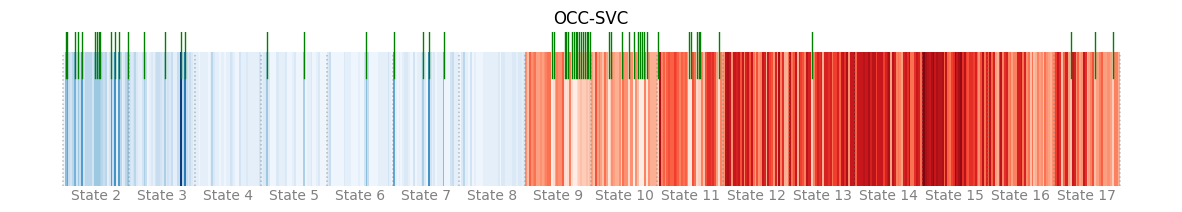

In [63]:
plot_colored_prog(slsvc, "OCC-SVC")

C:\Users\amroa\AppData\Local\Temp\ipykernel_18748\3049143631.py:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



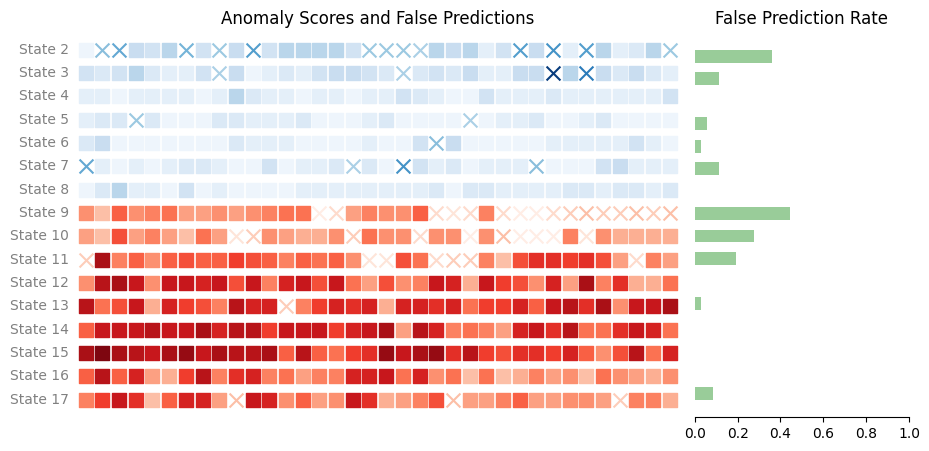

In [64]:
plot_grid(slsvc)

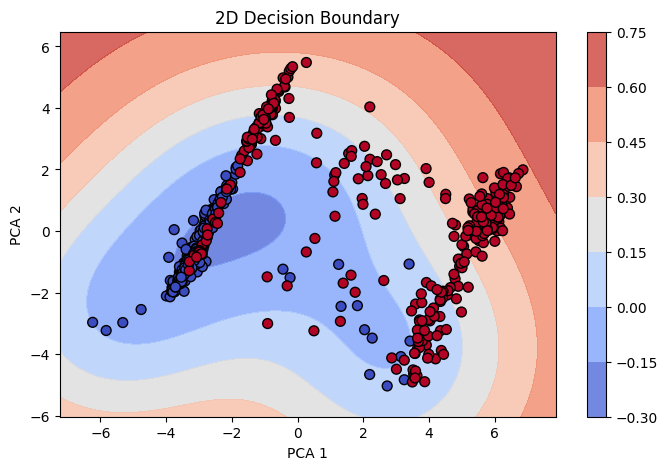

In [65]:
plot_decision_boundary_2D_v2(slsvc.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

576
17


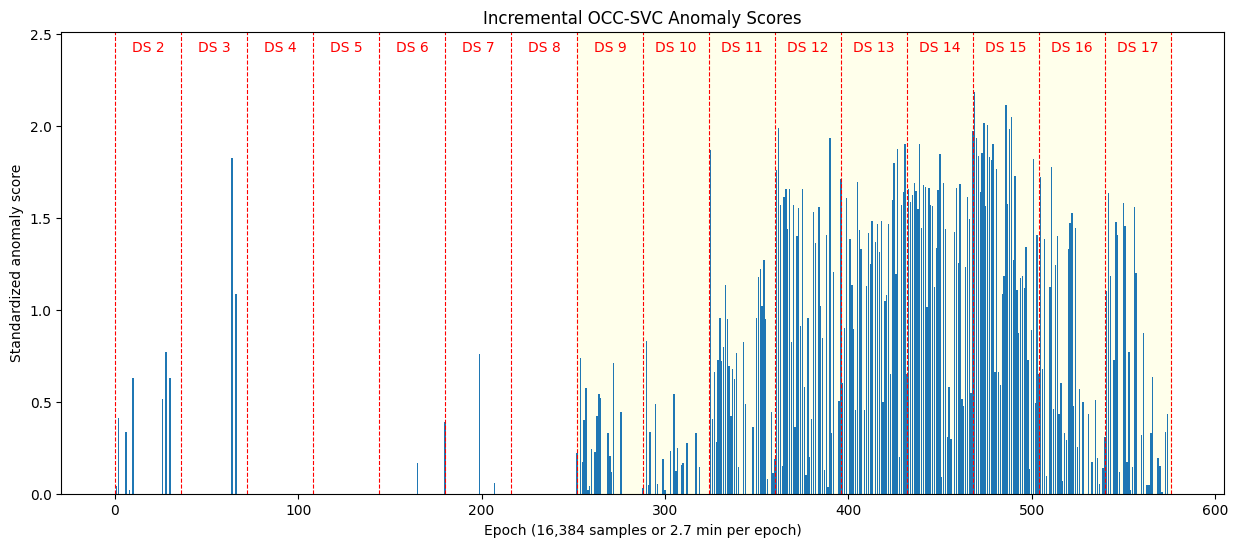

In [66]:
plot_anom(slsvc, "Incremental OCC-SVC Anomaly Scores")

### Half space trees

In [67]:
from river import compose
from river import preprocessing

class IncrementalHalfSpace():
    def __init__(self, h_len, size = 36, n_trees = 70, height  = 3):
        self.hst = compose.Pipeline(preprocessing.MinMaxScaler(), 
                                    anomaly.HalfSpaceTrees(n_trees=n_trees, height=height, window_size=size, seed=42))
        self.ctr = 0
        self.an_sc = [] # anomaly scores 
        self.h_len = h_len # number of healthy data points to expect 
        self.threshold = 0.7

    def update(self, data):
        data = {f'x_{i}': val  for i, val in enumerate(data)}
        self.ctr += 1
        self.hst = self.hst.learn_one(data)

    def predict_proba(self, data):
        if data.ndim == 1:
            data = {f'x_{i}': val  for i, val in enumerate(data)}
            sc = self.hst.score_one(data)
            self.an_sc.append(sc) 
            # to find if an anomaly is in fact anomalous, we must have a (running) distribution of anomalies
            if len(self.an_sc)> 1:
                ans = [sc- self.threshold]
                return ans
            else: 
                return [sc- self.threshold] 
        else:
            scores = []
            for el in data:
                inst = {f'x_{i}': val  for i, val in enumerate(el)}
                scores.append(self.hst.score_one(inst) - self.threshold) 
            return scores
        
    def decision_function(self, data):
        return self.predict_proba(data)
        
    def predict(self, data):
        if data.ndim == 1:
            data = {f'x_{i}': val  for i, val in enumerate(data)}
            sc = self.hst.score_one(data)
            if sc > self.threshold:
                return [-1]
            else:
                return [1]
        else:
            scores = []
            mu = np.mean(self.an_sc)
            sigma = np.std(self.an_sc)
            for el in data:
                inst = {f'x_{i}': val for i, val in enumerate(el)}
                sc = self.hst.score_one(inst)
                if sc > self.threshold:
                    scores.append(-1)
                else:
                    scores.append(1)
            return scores

In [109]:
param_grid_half = {
    'size': [15, 30],
    'height': [3, 4],
    'n_trees': [10, 50, 100]
}

In [110]:
max_score = -10
memorize_params_half = {}
for size in param_grid_half['size']:
    for height in param_grid_half['height']:
        for n_trees in param_grid_half['n_trees']:
            slhst = StreamLearning(healthy_data_top, damage_data_top, IncrementalHalfSpace(healthy_data_top.shape[0], size = size, n_trees= n_trees, height=height), min_points_for_retraining=size)
            slhst.cross_validate()
            avg_score = np.mean(slhst.val_scores)
            if max_score < avg_score:
                max_score = avg_score
                memorize_params_half = {'size': size, 'height': height, 'n_trees': n_trees}

In [111]:
memorize_params_half, max_score

({'size': 15, 'height': 3, 'n_trees': 10}, 0.9920634920634921)

In [136]:
memorize_params_half = {'size': 15, 'height': 3, 'n_trees': 10}

In [135]:
slhs = StreamLearning(healthy_data_top, damage_data_top,  IncrementalHalfSpace(h_len = healthy_data_top.shape[0], size = 15, height=3, n_trees=10), min_points_for_retraining=18)
slhs.loop()
print_metrics(slhs)

cor_d_preds 180 cor_h_preds (do not use) 286 d_pred_len 324 h_pred_len 288
fp count 5 first damage index 0


In [45]:
np.save("arr_an_hst.npy", np.array(slhs.clf.an_sc)) 

In [137]:
slhs_reset = StreamLearning(healthy_data_top, damage_data_top, IncrementalHalfSpace(h_len = healthy_data_top.shape[0], **memorize_params_half), min_points_for_retraining=18, reset_clf=True)
slhs_reset.loop()
print_metrics(slhs_reset)

cor_d_preds 191 cor_h_preds (do not use) 276 d_pred_len 324 h_pred_len 288
fp count 13 first damage index 0


In [138]:
1+(np.array(slhs.an_inst)//36) # sanity check to make sure green bars are correct in the anomaly color plot

array([2, 2, 2, 3, 3])

In [139]:
x1 = [0]*9 + slhs.d_pred_proba
x2 = [0]*9 + slhs.d_preds
print([el for el in zip(x1[36:36*2], x2[36:36*2])]) # sc 10 

[(-0.37911111111111107, 1), (-0.34977777777777774, 1), (-0.21377777777777773, 1), (-0.195111111111111, 1), (-0.14177777777777778, 1), (-0.016444444444444373, 1), (-0.195111111111111, 1), (-0.01911111111111108, 1), (-0.195111111111111, 1), (0.05555555555555558, -1), (-0.02444444444444438, 1), (0.04400000000000004, -1), (0.06355555555555559, -1), (0.04400000000000004, -1), (-0.02444444444444438, 1), (-0.059111111111111114, 1), (0.0004444444444444695, -1), (0.05555555555555558, -1), (-0.34977777777777774, 1), (-0.15155555555555544, 1), (0.04400000000000004, -1), (0.04400000000000004, -1), (-0.02444444444444438, 1), (-0.06711111111111112, 1), (-0.0057777777777776596, 1), (-0.059111111111111114, 1), (0.06266666666666665, -1), (0.0004444444444444695, -1), (0.132, -1), (-0.2884444444444444, 1), (0.06355555555555559, -1), (0.06266666666666665, -1), (-0.46977777777777774, 1), (0.06355555555555559, -1), (0.0004444444444444695, -1), (-0.5124444444444444, 1)]


In [140]:
fn_idx = np.where(np.array(slhs.d_preds) > 0)[0] + slhs.first_dam_idx + slhs.h_data.shape[0]
print(fn_idx)
print([[36*i, 36*(i+1)] for i in range(8, 17)])

[289 295 302 303 304 309 310 311 313 314 315 316 317 318 319 320 321 322
 323 325 329 330 333 334 337 338 339 340 344 347 350 351 352 354 355 357
 358 359 360 362 376 377 378 381 382 383 385 393 395 396 400 405 407 412
 415 416 419 422 423 425 427 429 430 431 436 440 444 445 450 455 464 468
 487 490 491 493 495 503 518 519 520 521 526 528 529 530 531 532 533 534
 535 536 538 539 540 542 544 545 548 551 552 553 554 555 559 561 562 563
 564 565 566 567 568 569 570 571 572 573 574 575 580 584 585 588 590 591
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611]
[[288, 324], [324, 360], [360, 396], [396, 432], [432, 468], [468, 504], [504, 540], [540, 576], [576, 612]]


In [141]:
slhs.h_pred_proba[1], np.nanmean(slhs.h_pred_proba[2:])

(-0.1577777777777778, -0.3547128888888888)

In [142]:
#slhs.h_pred_proba[1] = np.nanmean(slhs.h_pred_proba[2:]) # just to avoid issues withh plotting color anomaly map

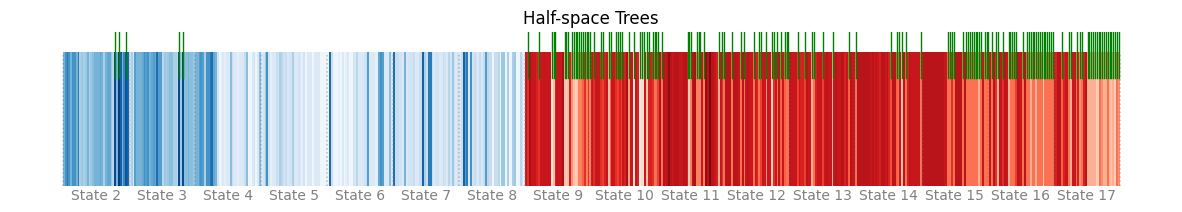

In [143]:
%matplotlib inline
plot_colored_prog(slhs, "Half-space Trees", width_an = 1)

C:\Users\amroa\AppData\Local\Temp\ipykernel_18748\3049143631.py:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



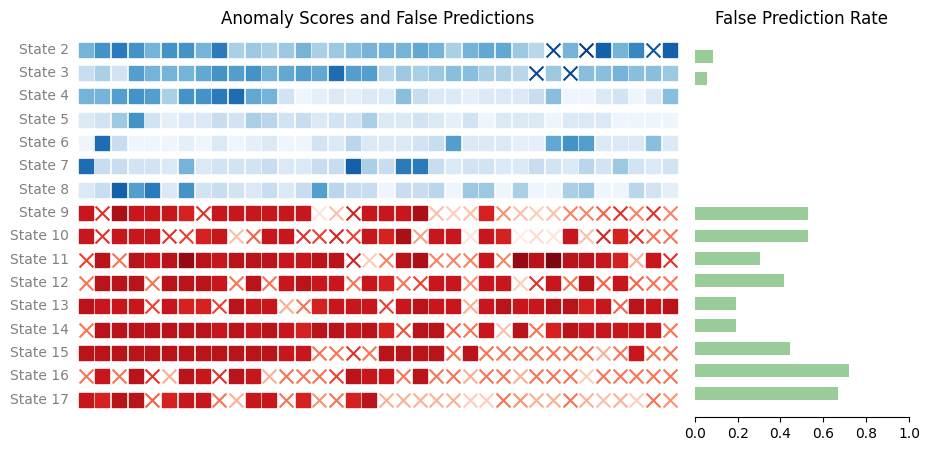

In [144]:
plot_grid(slhs)

576
17


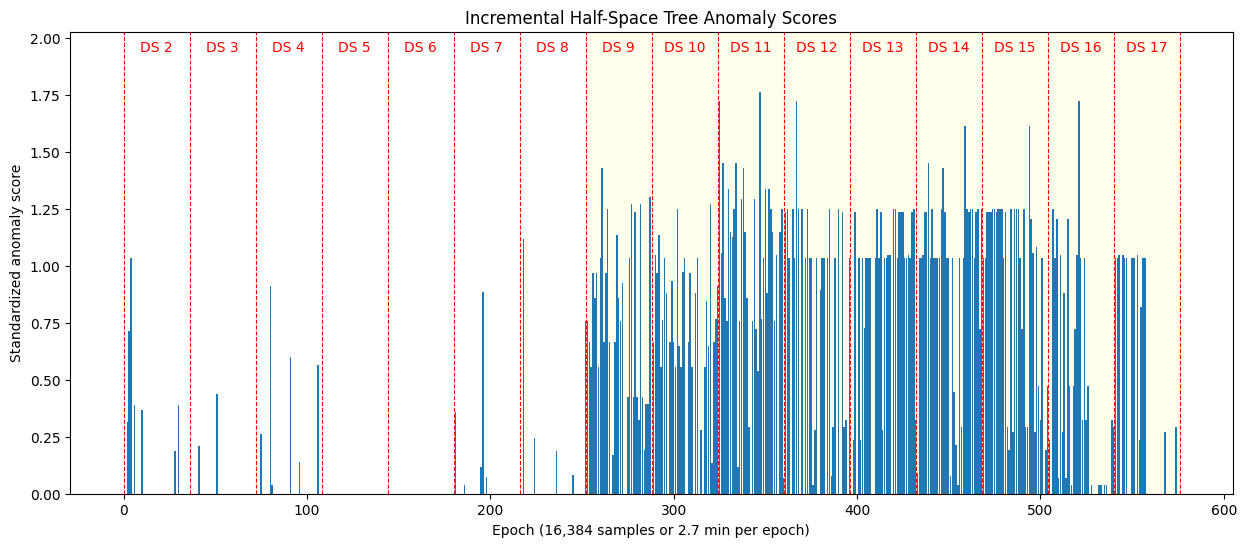

In [63]:
%matplotlib inline
plot_anom(slhs, "Incremental Half-Space Tree Anomaly Scores")

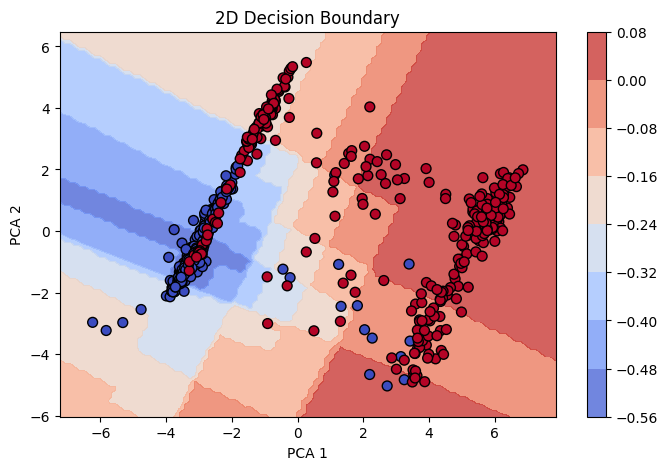

In [145]:
plot_decision_boundary_2D_v2(slhs.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

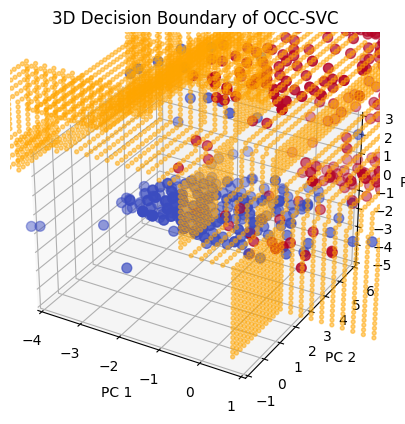

In [154]:
plot_decision_boundary(slhs.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

###  (Naive) Local outlier factor

In [146]:
from sklearn.neighbors import LocalOutlierFactor

class IncrementalLOF(): 
    def __init__(self, n_neighbors, max_size = 36):
        self.queue = []
        self.max_size = max_size # maximum size of the queue
        self.lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=True)

    def update(self, new_point):
        self.queue.append(new_point)
        if len(self.queue) == self.max_size:
            self.lof.fit(self.queue)
            self.queue.pop(0)
        elif len(self.queue) > self.max_size:
            self.queue.pop(0)
    
    def predict_proba(self, points):
        if points.ndim == 1:
            points = np.array([points])
        return -self.lof.decision_function(points)
    
    def decision_function(self, points):
        return self.predict_proba(points)
    
    # unlike predict_proba, negative corresponds to an anomaly, positive to an inlier
    def predict(self, points):
        if points.ndim == 1:
            points = np.array([points])
        return self.lof.predict(points)

In [147]:
param_grid_lof_naive = {
    'max_size': [9, 18, 36],
    'n_neighbors': [3, 6, 12, 24] # must be smaller than max size
}

In [148]:
max_score = -10
param_grid_naive_lof = {}
for size in param_grid_lof_naive['max_size']:
    for neighbors in param_grid_lof_naive['n_neighbors']:
            if neighbors >= size:
                 continue
            slof = StreamLearning(healthy_data_top, damage_data_top, IncrementalLOF(n_neighbors=neighbors, max_size=size) , min_points_for_retraining=size)
            slof.cross_validate()
            avg_score = np.mean(slof.val_scores)
            if max_score < avg_score:
                max_score = avg_score
                memorize_params_lof = {'max_size': size, 'n_neighbors': neighbors}

In [149]:
max_score, memorize_params_lof

(0.9285714285714286, {'max_size': 18, 'n_neighbors': 12})

In [150]:
memorize_params_lof = {'max_size': 18, 'n_neighbors': 12}

In [151]:
slof = StreamLearning(healthy_data_top, damage_data_top,  IncrementalLOF(**memorize_params_lof), min_points_for_retraining=18)
slof.loop()
print_metrics(slof)

cor_d_preds 298 cor_h_preds (do not use) 267 d_pred_len 324 h_pred_len 288
fp count 23 first damage index 0


In [152]:
slof_reset = StreamLearning(healthy_data_top, damage_data_top,  IncrementalLOF(**memorize_params_lof), min_points_for_retraining=18, reset_clf=True)
slof_reset.loop()
print_metrics(slof_reset)

cor_d_preds 312 cor_h_preds (do not use) 243 d_pred_len 324 h_pred_len 288
fp count 27 first damage index 0


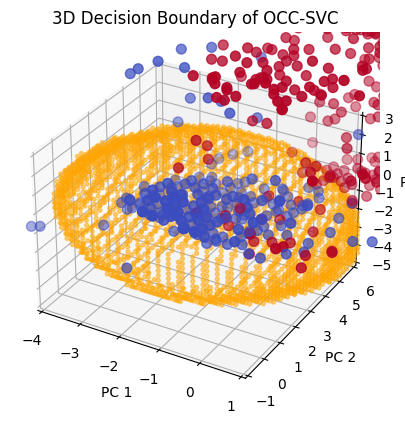

In [153]:
plot_decision_boundary(slof.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

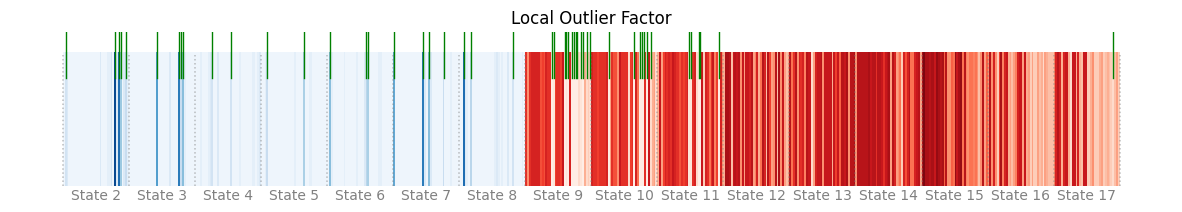

In [155]:
plot_colored_prog(slof, "Local Outlier Factor")

C:\Users\amroa\AppData\Local\Temp\ipykernel_18748\3049143631.py:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



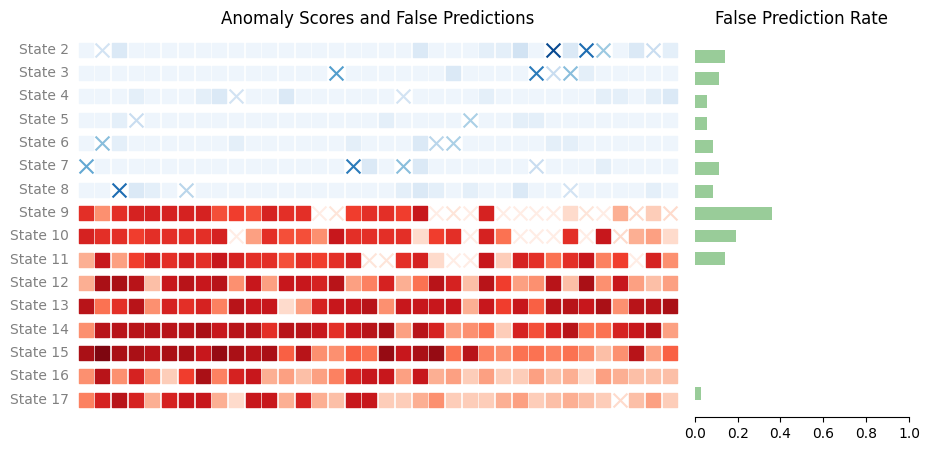

In [156]:
plot_grid(slof)

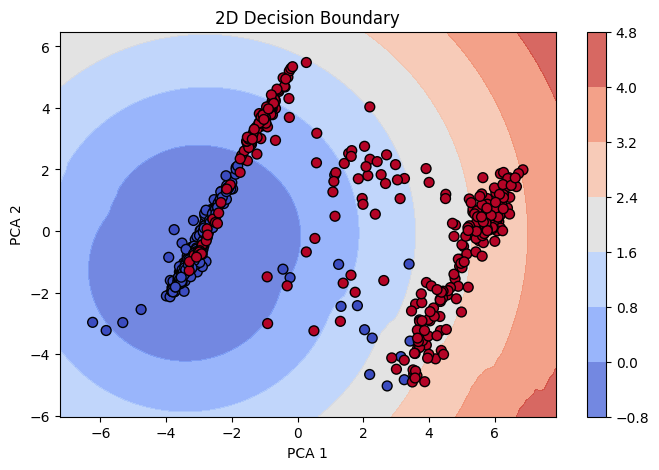

In [157]:
plot_decision_boundary_2D_v2(slof.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1)))) 

576
17


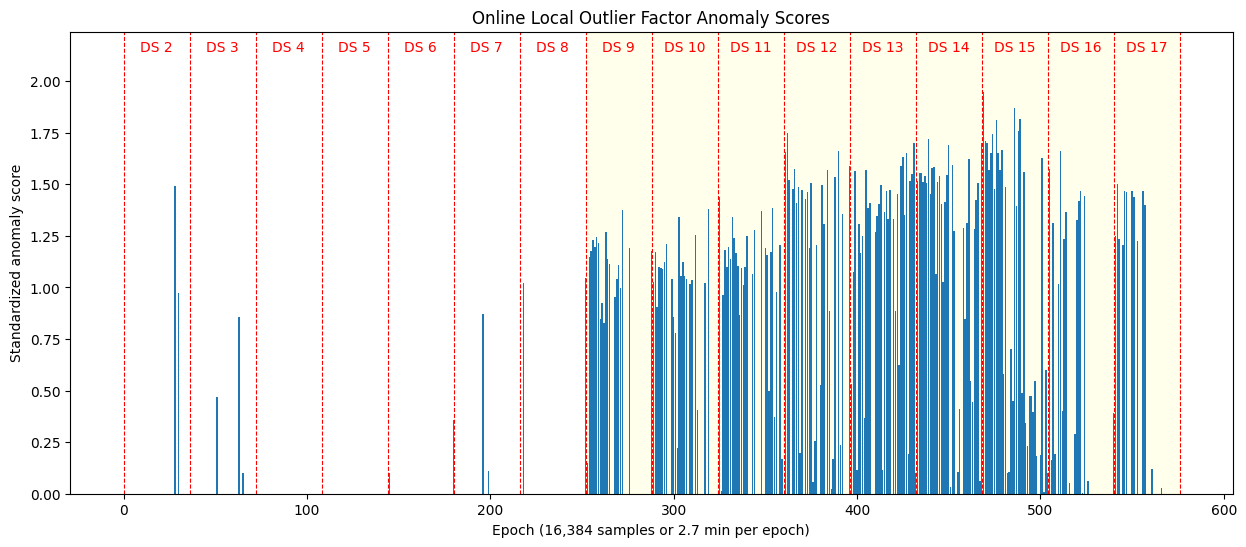

In [158]:
%matplotlib inline
plot_anom(slof, "Online Local Outlier Factor Anomaly Scores")

### LOF with non-decreasing density

In [278]:
# Re-importing necessary libraries and redefining the LOFWithLRD class
# as the code execution state has been reset.
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

class LOFWithLRD:
    def __init__(self, max_size = 36, n_neighbors=20):
        """
        Initialize the LOFWithLRD class.
        :param n_neighbors: number of neighbors to consider for LOF and LRD calculation.
        """
        self.n_neighbors = n_neighbors
        self.neighbors = None
        self.lrd = None
        self.max_size = max_size
        self.lof_scores = None
        self.queue = []
        self.prev_lrd = []
        self.cur_lrd = []
    
    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def update(self, new_point):
        self.lock = False
        self.queue.append(new_point)
        while (len(self.queue) > self.max_size):
            self.queue.pop(0)

    def reachability(self, distances, distances_to_new_point, points, indices_neighbors):
        kdistances = distances[indices_neighbors, -1]
        reachabilities = np.maximum(distances_to_new_point, kdistances)
        return reachabilities
    
    def calculate_lrd(self, nn_distances,  new_point):
        distances = np.array([self._euclidean_distance(new_point, point) for point in self.queue])
        neighbor_indices = (np.argsort(distances)[:self.n_neighbors]).astype(int)
        reachability = self.reachability(nn_distances, distances[neighbor_indices], self.queue, neighbor_indices)
        lrd = 1/np.mean(reachability)
        return lrd, neighbor_indices

    def predict_proba(self, new_point):
        if new_point.ndim == 1:
            new_point = np.array([new_point])
        scores = []
        for pt in new_point:
            # calculate nearest neighbors
            nn = NearestNeighbors(n_neighbors= self.n_neighbors).fit(self.queue)
            distances, _ = nn.kneighbors(self.queue)

            # get the nearest k neighbors of new point
            new_point_lrd, neighbor_indices = self.calculate_lrd(distances, pt)
            self.cur_lrd =  [self.calculate_lrd(distances, point)[0] for point in self.queue]
            if len(self.prev_lrd) == 0:
                self.true_lrd =self.cur_lrd
            else:
                if not self.lock:
                    self.prev_lrd.append(1000000)
                    self.prev_lrd.pop(0)
                    self.true_lrd = np.mean((self.prev_lrd, self.cur_lrd), axis = 0).tolist()
                    self.true_lrd[-1] = self.cur_lrd[-1]

            neighbor_lrd = [self.true_lrd[ni] for ni in neighbor_indices]
            self.prev_lrd = self.true_lrd
            scores.append(np.mean(neighbor_lrd)/new_point_lrd)
        self.lock = True
        return scores
    
    def predict(self, new_point):
        if new_point.ndim == 1:
            new_point = np.array([new_point])
        scores = []
        for pt in new_point:
            prob_pred = self.predict_proba(pt)[0]
            if prob_pred > 1.5:
                scores.append(-1)
            else:
                scores.append(1)
        return scores


In [268]:
param_grid_lof_mod = {
    'max_size': [9, 18, 36],
    'n_neighbors': [3, 6, 12, 24] # must be smaller than max size
}

In [281]:
slof = StreamLearning(healthy_data_top, damage_data_top,  LOFWithLRD(max_size=36, n_neighbors=24), min_points_for_retraining=36, reset_clf=False)
slof.loop()
print_metrics(slof)

cor_d_preds 206 cor_h_preds (do not use) 283 d_pred_len 322 h_pred_len 288
fp count 21 first damage index 2


In [279]:
max_score = -10
param_grid_lof = {}
for size in param_grid_lof_mod['max_size']:
    for neighbors in param_grid_lof_mod['n_neighbors']:
            if neighbors >= size:
                 continue
            slof = StreamLearning(healthy_data_top, damage_data_top, LOFWithLRD(max_size=size, n_neighbors=neighbors) , min_points_for_retraining=size)
            slof.cross_validate()
            avg_score = np.mean(slof.val_scores)
            if max_score < avg_score:
                max_score = avg_score
                memorize_params_lof = {'max_size': size, 'n_neighbors': neighbors}

In [280]:
memorize_params_lof, max_score
# output (for maximum in LRD: {'max_size': 18, 'n_neighbors': 12}, 0.9246031746031746)
# output (for minimum in LRD: {'max_size': 36, 'n_neighbors': 24}, 0.9761904761904763)

({'max_size': 36, 'n_neighbors': 24}, 0.9285714285714286)

### Entropy-guided elliptic envelopes

In [159]:
from river import active
from river import linear_model
from river import metrics

class EntropyGuidedEnvelopes(): 
    def __init__(self, nu = 0.1, significance = 1, entropy_window=10):
        self.metric = metrics.Accuracy()
        self.base_model = linear_model.LogisticRegression(l2 = nu)
        self.model = active.EntropySampler(self.base_model, discount_factor=1, seed=42)
        self.envelopes = [IncrementalGaussianFitter()]
        self.last_entropies = []
        self.sig = significance
        self.last_two = [] # for stability of the Gaussian we need to keep the last 2 points
        self.entropy_window = entropy_window
    
    @staticmethod
    def calculate_entropy(y_pred):
        probabilities = y_pred
        entropy = -sum(p * np.log2(p) for p in probabilities.values() if p > 0)
        return entropy

    def update(self, data):
        data_dict = {f'x_{i}': val  for i, val in enumerate(data)}
        y_pred, ask = self.model.predict_proba_one(data_dict) 
        if ask:
            self.model.learn_one(data_dict, 0)
        entropy_cur = EntropyGuidedEnvelopes.calculate_entropy(y_pred)
        
        # make sure the size of our entropy queue does not exceed entropy_window
        if len(self.last_entropies) < self.entropy_window:
            self.last_entropies.append(entropy_cur)
            # fit the current gaussian fitter to it
            self.envelopes[-1].update(data)
        else:
            while len(self.last_entropies) != self.entropy_window:
                self.last_entropies.pop(0)
            # now size self.last_entropies contains entropy_window elements
            
            if entropy_cur > self.sig*np.std(self.last_entropies) + np.mean(self.last_entropies):
                # this entropy is with ~70% confidence much larger than previous entropies
                # hence, create a new envelope
                self.envelopes.append(IncrementalGaussianFitter())
                self.envelopes[-1].update(data)
                for pt in self.last_two:
                    self.envelopes[-1].update(pt)
            else:
                # this entropy is more or less the same as the previous, hence roughly the same distribution
                # --> belongs to the same envelope as the previous
                self.envelopes[-1].update(data)
            self.last_entropies.append(entropy_cur)

            # for stability of the Gaussian we need to keep the last 2 points
            self.last_two.append(data)
            while len(self.last_two) > 3:
                self.last_two.pop(0)

    def predict_proba(self, points):
        if points.ndim == 1:
            points = np.array([points])
        #print(self.envelopes[-1].count)
        return self.envelopes[-1].predict_proba(points)
    
    def decision_function(self, points):
        return self.predict_proba(points)
    
    def predict(self, points):
        if points.ndim == 1:
            points = np.array([points])
        return self.envelopes[-1].predict(points)

In [357]:
param_grid_eng = {'nu': [0.1, 0.3, 0.6], 'significance': [1, 2, 3], 'entropy_window': [5, 10, 15, 20]}

In [358]:
max_score = -10
memorize_params_eng = {}
for nu in param_grid_eng['nu']:
    for sig in param_grid_eng['significance']:
        for win in param_grid_eng['entropy_window']:
            sleng = StreamLearning(healthy_data_top, damage_data_top, EntropyGuidedEnvelopes(nu = nu, significance=sig, entropy_window=win) , min_points_for_retraining=1)
            sleng.cross_validate()
            avg_score = np.mean(sleng.val_scores)
            if max_score < avg_score:
                max_score = avg_score
                memorize_params_eng = {'nu': nu, 'significance': sig, 'entropy_window': win}

In [359]:
memorize_params_eng, max_score

({'nu': 0.3, 'significance': 3, 'entropy_window': 15}, 0.9047619047619049)

In [360]:
slen = StreamLearning(healthy_data_top, damage_data_top, EntropyGuidedEnvelopes(nu = 0.3, significance=3, entropy_window=15), min_points_for_retraining=1, reset_clf=False)
slen.loop()
print_metrics(slen)

cor_d_preds 289 cor_h_preds (do not use) 261 d_pred_len 324 h_pred_len 288
fp count 26 first damage index 0


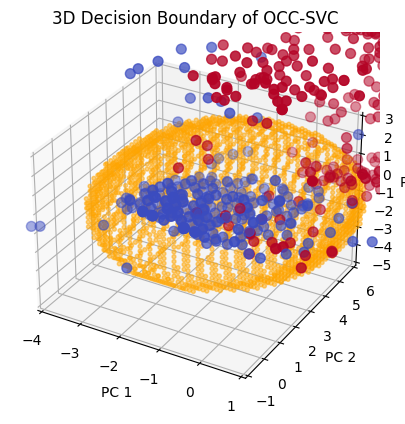

In [361]:
plot_decision_boundary(slen.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

In [363]:
slen.clf.envelopes[-1].count, len(slen.clf.envelopes), [slen.clf.envelopes[i].count for i in range(2)]

(89, 2, [202, 89])

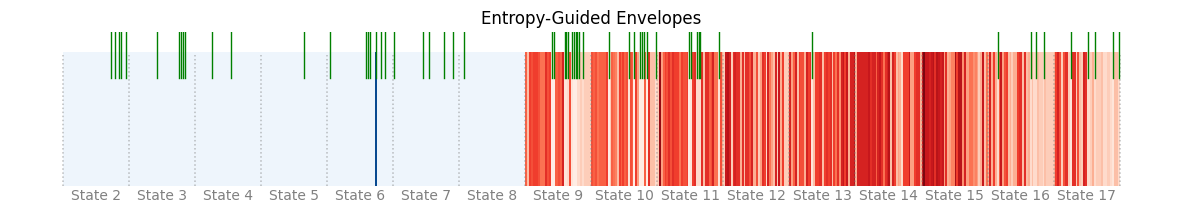

In [364]:
plot_colored_prog(slen, "Entropy-Guided Envelopes")

C:\Users\amroa\AppData\Local\Temp\ipykernel_18748\3049143631.py:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



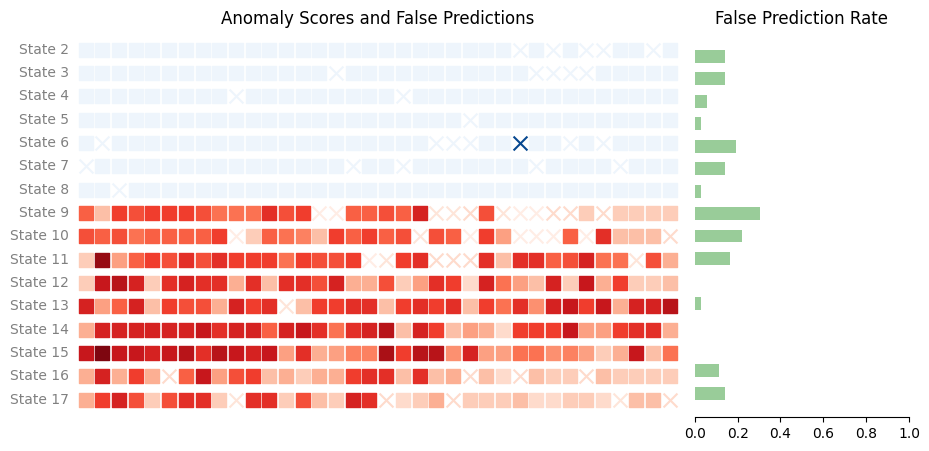

In [365]:
plot_grid(slen)

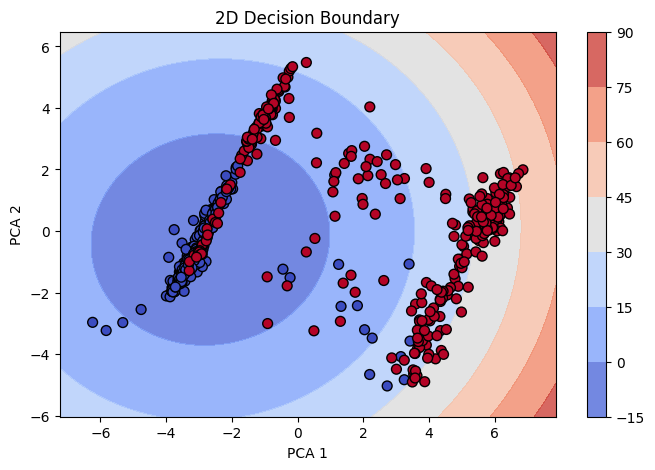

In [366]:
plot_decision_boundary_2D_v2(slen.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

576
17


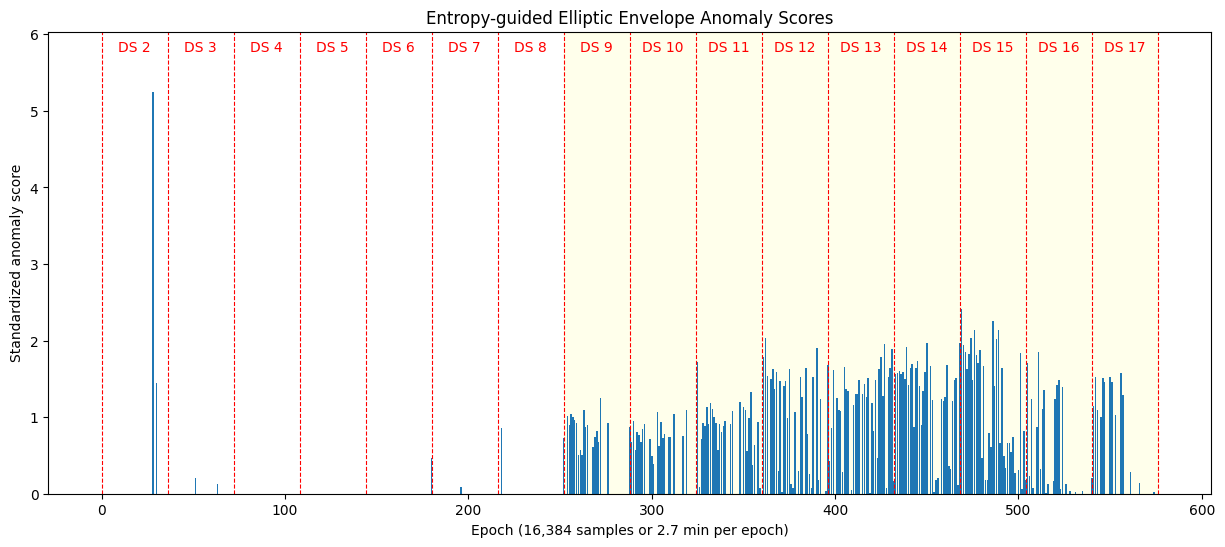

In [172]:
plot_anom(slen, "Entropy-guided Elliptic Envelope Anomaly Scores")

In [286]:
from river import metrics
from river import linear_model
from river import active

def calculate_entropy(y_pred):
    probabilities = y_pred
    entropy = -sum(p * np.log2(p) for p in probabilities.values() if p > 0)
    return entropy

X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in np.vstack((healthy_data_top, damage_data_top))
]
y_river = np.hstack((np.zeros(len(healthy_data_top)), np.ones(len(damage_data_top)))).tolist() 

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression(l2 = 0.3)
model = active.EntropySampler(base_model, discount_factor=1, seed=42)
n_samples_used = 0
entropies = []

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_proba_one(x) 
    entropy_cur = calculate_entropy(y_pred)
    entropies.append(entropy_cur)
    if ask:
        n_samples_used += 1
        model = model.learn_one(x, 0)  # Learn from the true label

576
17


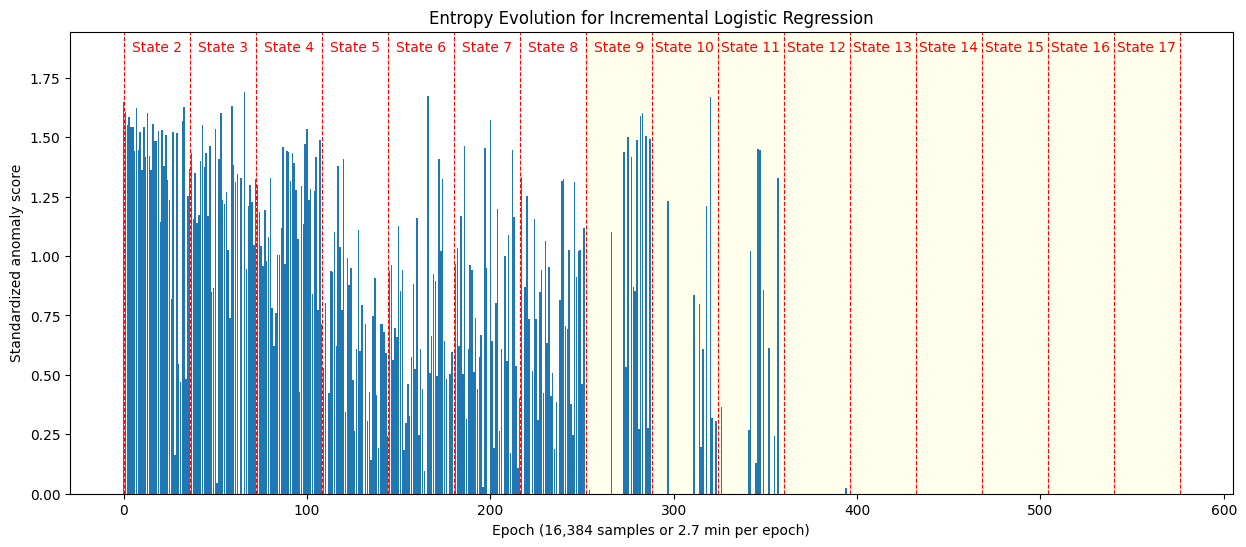

In [287]:
sns.reset_defaults()
sns.reset_orig()

plt.figure(figsize=(15, 6))
nbr_epochs = healthy_data_top.shape[0] - 36 + damage_data_top.shape[0]
print(nbr_epochs)

an_scores = np.hstack(entropies[36:]).reshape(-1, 1)
print(len(range(0, nbr_epochs+1, 36)))
for i in range(0, nbr_epochs+1, 36):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

# scale and plot the bars
sc = StandardScaler()
obs = np.arange(len(an_scores))
std_entropies = sc.fit_transform(an_scores).flatten()

plt.axvspan(36*7, 36*16, color='yellow', alpha=0.08)
plt.bar(obs, std_entropies)
plt.ylim(0, 1.15*max(std_entropies))

plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
plt.ylabel('Standardized anomaly score')
plt.title('Entropy Evolution for Incremental Logistic Regression')
text_pos = [i+18 for i in range(0, nbr_epochs, 36)]

# print title for each state
for idx, pos in enumerate(text_pos):
    str_capt =  f'State {idx+2}'
    plt.text(pos, max(std_entropies)*1.1, str_capt, ha='center', color='red')

plt.show()

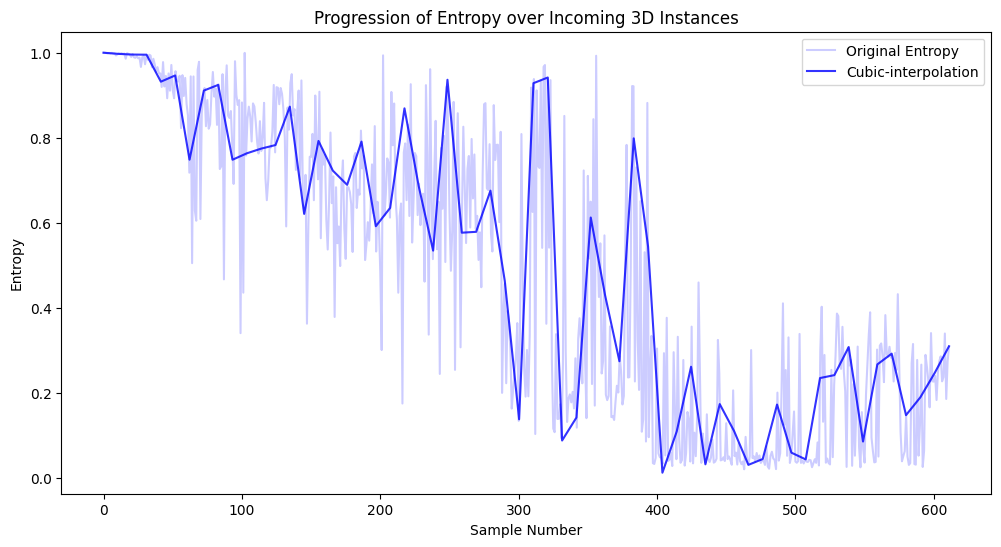

In [356]:
sample_numbers = np.arange(len(entropies)) 
fewer_points_smooth_sample_numbers = np.linspace(sample_numbers.min(), sample_numbers.max(), 60)

degree_3_spl = make_interp_spline(sample_numbers, entropies, k=3)  # Using degree 5
degree_3_smooth_entropy = degree_3_spl(fewer_points_smooth_sample_numbers)

plt.figure(figsize=(12, 6))
plt.plot(sample_numbers, entropies, label='Original Entropy', color='blue', alpha=0.2)
plt.plot(fewer_points_smooth_sample_numbers, degree_3_smooth_entropy, label='Cubic-interpolation', color='blue', alpha = 0.8)
plt.xlabel('Sample Number')
plt.ylabel('Entropy')
plt.title('Progression of Entropy over Incoming 3D Instances')
plt.legend()
plt.show()


### Random state

In [149]:
from numpy import random
class RandomClf(): 
    def __init__(self):
        random.seed(42)
        self.mapping = {}

    def update(self, new_point):
        # do nothing 
        pass
    
    def predict_proba(self, points):
        if points.ndim == 1:
            points = np.array([points])
        probs = []
        for pt in points:
            pt_tuple = tuple(pt)
            if pt_tuple not in self.mapping:
                self.mapping[pt_tuple] = random.rand()
            probs.append(self.mapping[pt_tuple])
        return probs
    
    def decision_function(self, points):
        return self.predict_proba(points)
    
    # unlike predict_proba, negative corresponds to an anomaly, positive to an inlier
    def predict(self, points):
        if points.ndim == 1:
            points = np.array([points])
        probs = self.predict_proba(points)
        result = [-1 if 2*el - 1 > 0 else 1 for el in probs]
        return result

In [150]:
slrnd = StreamLearning(healthy_data_top, damage_data_top, RandomClf(), min_points_for_retraining=0, reset_clf=False)
slrnd.loop()
print_metrics(slrnd)

cor_d_preds 180 cor_h_preds (do not use) 153 d_pred_len 324 h_pred_len 288
fp count 126 first damage index 0


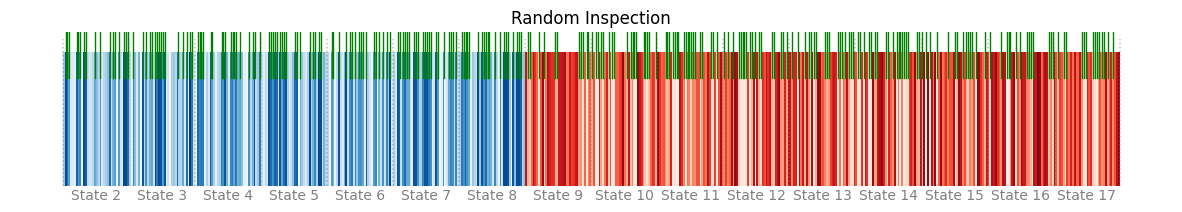

In [436]:
plot_colored_prog(slrnd, "Random Inspection")

C:\Users\amroa\AppData\Local\Temp\ipykernel_14376\4014694737.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


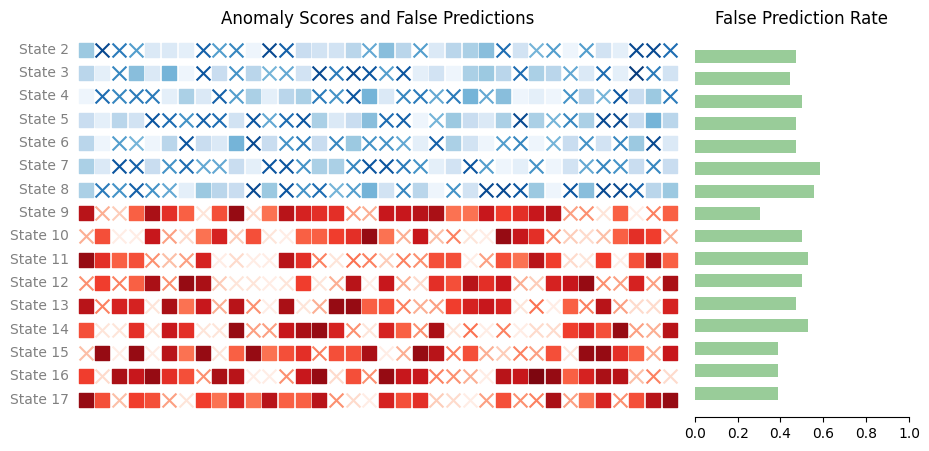

In [380]:
plot_grid(slrnd)

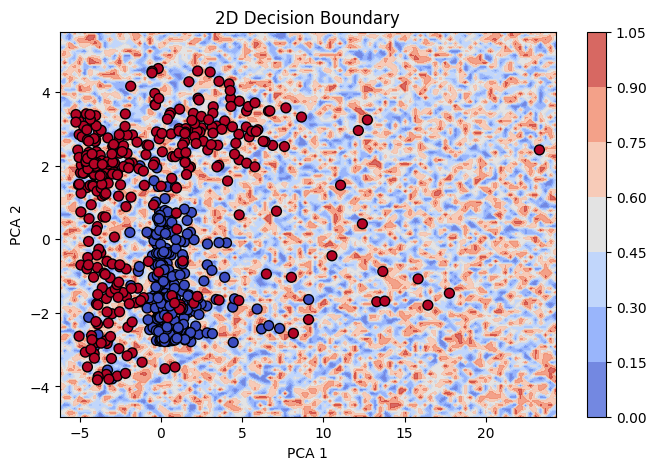

In [151]:
plot_decision_boundary_2D_v2(slrnd.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

## Save full statistics

In [367]:
np.save("slg_fp.npy", slg.an_inst)
np.save("slsvc_fp.npy", slsvc.an_inst)
np.save("slhs_fp.npy",  slhs.an_inst)
np.save("slof_fp.npy", slof.an_inst)
np.save("slen_fp.npy", slen.an_inst)

In [368]:
np.save("slg_d_pred.npy", slg.d_preds)
np.save("slsvc_d_pred.npy", slsvc.d_preds)
np.save("slhs_d_pred.npy",  slhs.d_preds)
np.save("slof_d_pred.npy", slof.d_preds)
np.save("slen_d_pred.npy", slen.d_preds)

In [369]:
slgd   = np.load("slg_d_pred.npy")
slsvcd = np.load("slsvc_d_pred.npy")
slhsd  = np.load("slhs_d_pred.npy")
slofd  = np.load("slof_d_pred.npy")
slend  = np.load("slen_d_pred.npy")

slg_fp   = np.load("slg_fp.npy")
slsvc_fp = np.load("slsvc_fp.npy")
slhs_fp  = np.load("slhs_fp.npy")
slof_fp  = np.load("slof_fp.npy")
slen_fp  = np.load("slen_fp.npy")

In [370]:
# Pad to 324 (nbr of dam samples)
total_damage_len = 324
slg_d  = np.append(np.ones(total_damage_len - len(slgd)), slgd)
svc_d  = np.append(np.ones(total_damage_len - len(slsvcd)), slsvcd)
slhs_d = np.append(np.ones(total_damage_len - len(slhsd)), slhsd)
slof_d = np.append(np.ones(total_damage_len - len(slofd)), slofd)
slen_d = np.append(np.ones(total_damage_len - len(slend)), slend)

In [371]:
# Concrete spalling: first two damage (0, 1)
# Landslide: third damage (2)
# Concrete hinge: fourth (3)
# Tendons: (4 - 8)

methods = [slg_d, svc_d, slhs_d, slof_d, slen_d]
concrete  = []
landslide = []
tendons   = []

for i in methods:
    # Three types of damage: concrete damage (spalling + hinges), landslide, tendons
    concrete_i  = np.hstack((i[0:36*2], i[36*3:36*4]))
    landslide_i = i[36*2:36*3]
    tendons_i   = i[36*4:]
    concrete.append(concrete_i)
    landslide.append(landslide_i)
    tendons.append(tendons_i)

In [372]:
healthy = [slg_fp, slsvc_fp, slhs_fp, slof_fp, slen_fp]

In [373]:
# Three barplots, one for each damage type
landslide_acc = [np.sum(np.array(el) < 0)/len(el) for el in landslide] 
tendons_acc   = [np.sum(np.array(el) < 0)/len(el) for el in tendons] 
concrete_acc  = [np.sum(np.array(el) < 0)/len(el) for el in concrete]
healthy_acc   = [(1 - len(el)/252) for el in healthy] 

In [374]:
all     = [np.hstack((el1, el2, el3)) for el1, el2, el3 in zip(concrete, landslide, tendons)]
all_acc = [np.sum(np.array(el) < 0)/len(el) for el in all] 

In [375]:
import matplotlib.pyplot as plt
import numpy as np

def compare_acc_damage_type(damage_acc, healthy_acc, color, type: str, acctype = "Test"):
    methods = ["Elliptic", "OC-SVC", "HST", "LOF", "EG"]
    n_methods = len(damage_acc)
    bar_width = 0.8
    index = np.arange(n_methods)
    fig, ax = plt.subplots(figsize = (3.5, 2))
    bar1 = ax.bar(index, damage_acc, bar_width, label=f"{type} Accuracy", color = color, alpha = 0.3)
    #bar2 = ax.bar(index + bar_width, healthy_acc, bar_width, label='Healthy Accuracy', color = "green", alpha = 0.3)
    ax.set_xlabel('Methods')
    ax.set_ylabel(f'{acctype} Accuracy')
    #ax.set_title(f'Accuracy Comparison between {type} and Healthy Data')
    ax.set_xticks(index )
    ax.set_xticklabels([f'{method}' for method in methods])
    ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.97))
    plt.show()


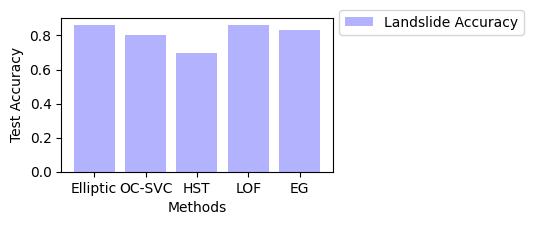

In [376]:
compare_acc_damage_type(landslide_acc, healthy_acc, color = 'blue', type= "Landslide")

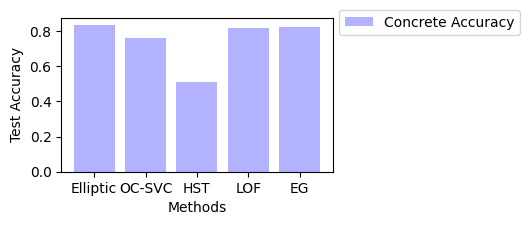

In [377]:
compare_acc_damage_type(concrete_acc, healthy_acc,  color = 'blue', type="Concrete")

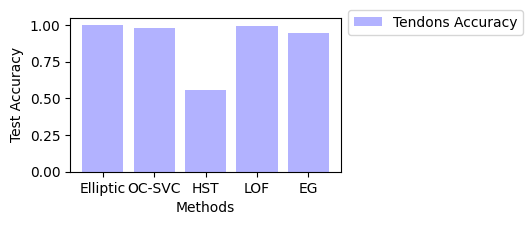

In [378]:
compare_acc_damage_type(tendons_acc, healthy_acc,  color = 'blue', type="Tendons")

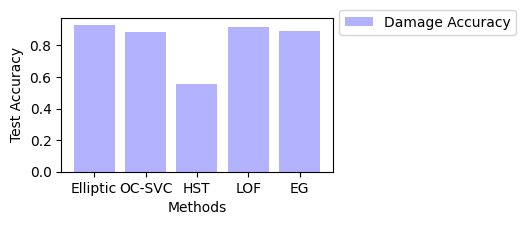

In [379]:
compare_acc_damage_type(all_acc, healthy_acc, color = "blue", type = "Damage")

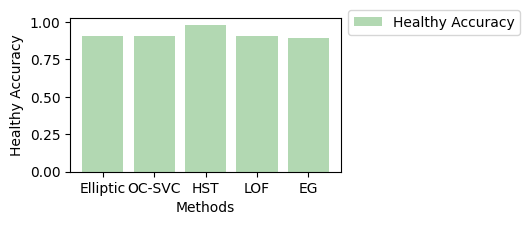

In [381]:
compare_acc_damage_type(healthy_acc, healthy_acc, color = "green", type = "Healthy", acctype="Healthy")

C:\Users\amroa\AppData\Local\Temp\ipykernel_18748\1970751836.py:10: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




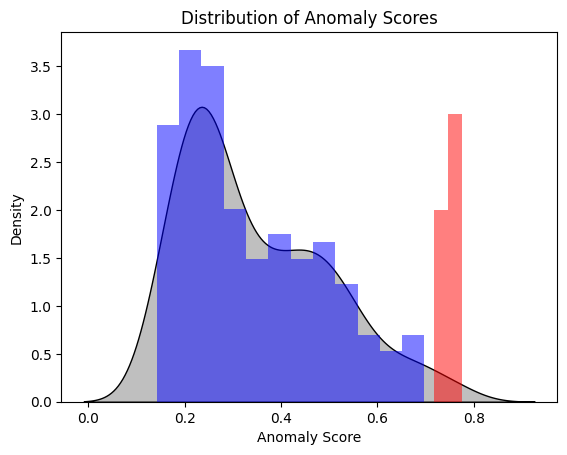

In [276]:
# HST anomaly distribution for healthy points
data = np.array(slhs.h_pred_proba) + 0.7
anomaly_indices = np.where(data >= 0.7)[0]
normal_indices  = [el for el in range(len(slhs.h_pred_proba)) if el not in anomaly_indices]
first_half = data[normal_indices]
second_half = data[anomaly_indices]
bins = 12

# KDE for the whole dataset
sns.kdeplot(data, color="k", shade=True)

# Histograms for normal and anomalous
plt.hist(first_half, bins=bins, color='blue', alpha=0.5, density=True)
plt.hist(second_half, bins=2, color='red', alpha=0.5, density=False)

plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')

plt.show()